In [1]:
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR, StepLR, MultiStepLR, ExponentialLR, ReduceLROnPlateau, CosineAnnealingLR

import torch.nn as nn
import torch.nn.functional as F

import torchvision 
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset

import copy
from copy import deepcopy

import argparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import pickle
import argparse
from collections import OrderedDict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
def createDirectory(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print("Error: Failed to create the directory.")

In [3]:
sleep_dir = 'C:/Users/WorkStation/Desktop/공모전/sleep_dataset/user_sleep_2020.csv'
survey_dir = 'C:/Users/WorkStation/Desktop/공모전/sleep_dataset/user_survey_2020.csv' 

sleep_df = pd.read_csv(sleep_dir).iloc[:,6:]
survey_df = pd.read_csv(survey_dir)
survey_df = survey_df.drop(survey_df[survey_df['amPm']=='pm'].index).iloc[:,6]

sleep_data = torch.Tensor(sleep_df.values).to(torch.float32)
survey_data = torch.Tensor(survey_df.values).to(torch.int64)

rand_idx = torch.randperm(len(sleep_data))

sleep_data = sleep_data[rand_idx]
survey_data = survey_data[rand_idx]

in_dim, out_dim = sleep_data.shape[1], survey_data.max()+1

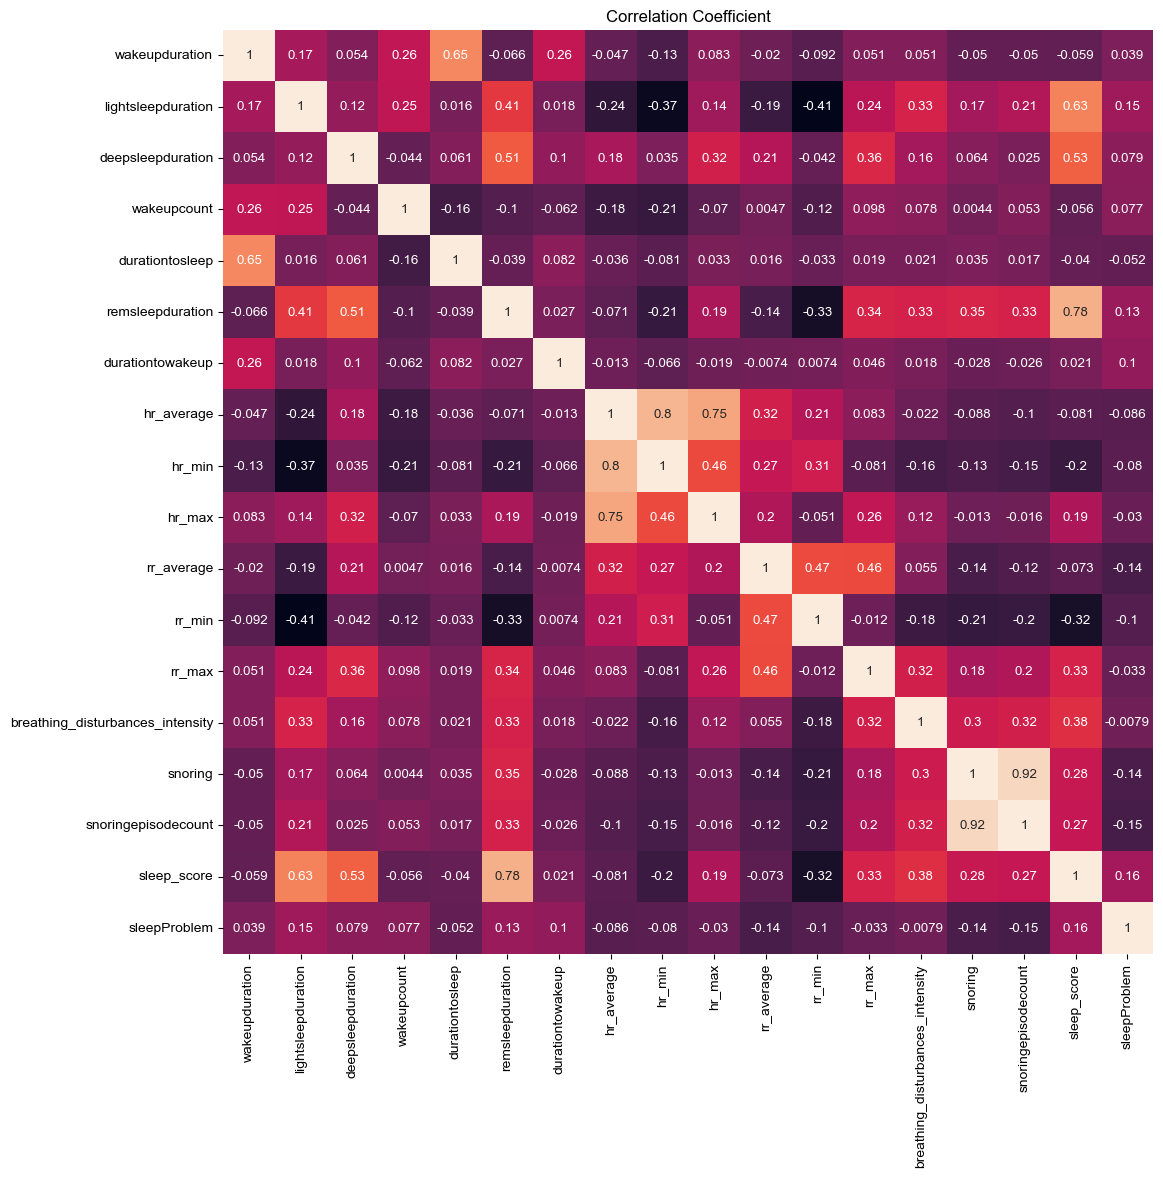

In [4]:
df = pd.concat([sleep_df, survey_df], axis=1)

corr_coef = df.corr()

plt.figure(figsize=(12,12))
plt.title('Correlation Coefficient')
sns.set(font_scale=0.8)
sns.heatmap(corr_coef, annot=True, cbar=False)
plt.show()

In [5]:
corr_descend = df.corr().loc[:'sleep_score', 'sleepProblem'].abs().sort_values(ascending=False)
print(corr_descend)
print('\n', corr_descend.keys())

feature_idx = []
for features in corr_descend.keys().to_numpy():
    a = np.where(sleep_df.columns == features)
    feature_idx.append(a[0][0])

print(f'\nfeature_idx: {feature_idx}')

sleep_score                         0.161063
snoringepisodecount                 0.149798
lightsleepduration                  0.147534
rr_average                          0.139561
snoring                             0.136614
remsleepduration                    0.133331
durationtowakeup                    0.103597
rr_min                              0.102417
hr_average                          0.085608
hr_min                              0.079848
deepsleepduration                   0.078852
wakeupcount                         0.076686
durationtosleep                     0.051810
wakeupduration                      0.039458
rr_max                              0.032905
hr_max                              0.030467
breathing_disturbances_intensity    0.007905
Name: sleepProblem, dtype: float64

 Index(['sleep_score', 'snoringepisodecount', 'lightsleepduration',
       'rr_average', 'snoring', 'remsleepduration', 'durationtowakeup',
       'rr_min', 'hr_average', 'hr_min', 'deepsleepduration

In [6]:
class Net(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act, dropout, use_bn, use_xavier):
        super(Net, self).__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act
        self.dropout = dropout
        self.use_bn = use_bn
        self.use_xavier = use_xavier


        # ===== Create Linear Layers ===== #
        self.fc1 = nn.Linear(self.in_dim, self.hid_dim)

        self.linears = nn.ModuleList()
        self.bns = nn.ModuleList()
        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
            if self.use_bn: self.bns.append(nn.BatchNorm1d(self.hid_dim))

        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)


        # ====== Create Activation Function ====== #
        if self.act == 'relu': self.act = nn.ReLU()
        elif self.act == 'leakyrelu': self.act = nn.LeakyReLU()
        elif self.act == 'tanh': self.act = nn.Tanh()
        elif self.act == 'sigmoid': self.act = nn.Sigmoid()
        else: raise ValueError('no valid activation function')


        # ====== Create Regularization Layer ======= #
        self.dropout = nn.Dropout(self.dropout)
        if self.use_xavier: self.xavier_init()


    def forward(self, x):
        x = self.act(self.fc1(x))
        for i in range(len(self.linears)):
            x = self.act(self.linears[i](x))
            x = self.bns[i](x)
            x = self.dropout(x)
        x = self.fc2(x)
        return x


    def xavier_init(self):
        for linear in self.linears:
            nn.init.xavier_normal_(linear.weight)
            linear.bias.data.fill_(0.01)

a = Net(in_dim, out_dim, 20, 3, 'relu', 0.25, True, True) # arbitrary hidden_dim
print(a)

Net(
  (fc1): Linear(in_features=17, out_features=20, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc2): Linear(in_features=20, out_features=10, bias=True)
  (act): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
)


In [7]:
def make_dataset(feature_idx, data, target, args):
    dataset = torch.utils.data.TensorDataset(data[:, feature_idx[:args.feat]], target)

    dataset_size = len(dataset)
    train_size = int(len(dataset) * 0.8)
    val_size = int(dataset_size * 0.1)
    test_size = dataset_size - (train_size + val_size)

    train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

    partition = {'train':train_set, 'val':val_set, 'test':test_set}
    
    return partition

def train(model, train_loader, criterion, optimizer, args): 
    train_loader = DataLoader(partition['train'], batch_size=args.train_batch_size, shuffle=True)

    correct, total = 0, 0
    train_loss = 0  

    for inputs, labels in iter(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad() 
            
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_loss /= len(train_loader)
    train_accuracy = (correct / total) * 100.0

    return model, train_loss, train_accuracy


def validate(model, partition, criterion, args):
    val_loader = DataLoader(partition['val'], batch_size=args.test_batch_size, shuffle=False)
    model.eval()
        
    correct, total = 0, 0 # 정답을 맞힌 이미지 개수, 전체 이미지 개수
    loss =  0

    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss += criterion(outputs, labels).item()

        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    val_loss = loss / len(val_loader)
    val_accuracy = (correct / total) * 100.0
    
    return val_loss, val_accuracy


def test(model, partition, args):
    test_loader = DataLoader(partition['test'], batch_size=args.test_batch_size, shuffle=False)
    model.eval()
        
    correct, total = 0, 0 # 정답을 맞힌 이미지 개수, 전체 이미지 개수

    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)

        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    test_accuracy = (correct / total) * 100.0
    
    return test_accuracy

In [8]:
def experiment(partition, args):
    model = Net(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act, args.dropout, args.use_bn, args.use_xavier).to(device)
    
    criterion = nn.CrossEntropyLoss()
    
    if args.optim == 'SGD': optimizer = optim.SGD(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop': optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam': optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)
    else: raise ValueError('In-valid optimizer choice')
    
    train_losses, train_acces = [], []
    val_losses, val_acces = [], []

    for epoch in range(args.epochs):
        model, train_loss, train_acc = train(model, partition, criterion, optimizer, args)
        val_loss, val_acc = validate(model, partition, criterion, args)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_acces.append(train_acc)
        val_acces.append(val_acc)

        if epoch%500 == 0 or epoch==(args.epochs-1):
            print(f'[Epoch {epoch}]  Train Loss: {train_loss}  Train Acc: {train_acc:.2f}  Val Loss: {val_loss}  Train Acc: {val_acc:.2f}')
        
    test_acc = test(model, partition, args)    

    return train_losses, val_losses, train_acces, val_acces


In [9]:
def plot_loss(train_losses, val_losses, train_acces, val_acces):
    plt.figure(figsize=(8, 3))
    
    plt.subplot(1,2,1)
    plt.plot(train_losses, label = 'Train')
    plt.plot(val_losses, label = 'Val')
    plt.xlabel('Rounds')
    plt.grid()
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_acces, label = 'Train')
    plt.plot(val_acces, label = 'Val')
    plt.xlabel('Rounds')
    plt.grid()
    plt.legend()

    plt.show()

#### **Ex0) *Feature Searching***

# ===== feat: 2 ===== #
[Epoch 0]  Train Loss: 2.439173310995102  Train Acc: 6.71  Val Loss: 2.4954378604888916  Train Acc: 1.64
[Epoch 500]  Train Loss: 1.6566372513771057  Train Acc: 55.28  Val Loss: 1.7495185136795044  Train Acc: 54.10
[Epoch 1000]  Train Loss: 1.555730789899826  Train Acc: 55.28  Val Loss: 1.6585190296173096  Train Acc: 54.10
[Epoch 1500]  Train Loss: 1.5299152731895447  Train Acc: 55.28  Val Loss: 1.620947003364563  Train Acc: 54.10
[Epoch 2000]  Train Loss: 1.5189866870641708  Train Acc: 55.28  Val Loss: 1.6088560819625854  Train Acc: 54.10
[Epoch 2500]  Train Loss: 1.509536936879158  Train Acc: 55.28  Val Loss: 1.605107307434082  Train Acc: 54.10
[Epoch 2999]  Train Loss: 1.5021887868642807  Train Acc: 55.28  Val Loss: 1.6032185554504395  Train Acc: 54.10


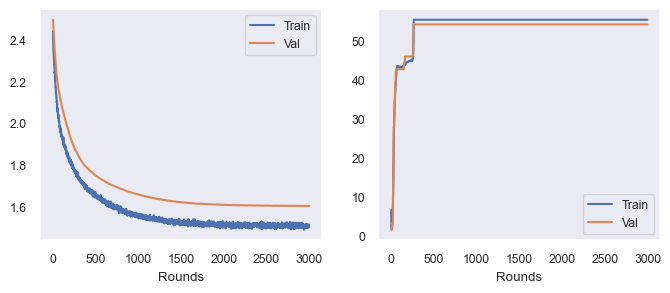

# ===== feat: 3 ===== #
[Epoch 0]  Train Loss: 2.3795738220214844  Train Acc: 7.32  Val Loss: 2.7023720741271973  Train Acc: 3.28
[Epoch 500]  Train Loss: 1.637944445014  Train Acc: 52.85  Val Loss: 1.3708176612854004  Train Acc: 68.85
[Epoch 1000]  Train Loss: 1.590650424361229  Train Acc: 53.25  Val Loss: 1.3112231492996216  Train Acc: 68.85
[Epoch 1500]  Train Loss: 1.5735727399587631  Train Acc: 53.25  Val Loss: 1.2899588346481323  Train Acc: 68.85
[Epoch 2000]  Train Loss: 1.5597582012414932  Train Acc: 53.25  Val Loss: 1.280096173286438  Train Acc: 68.85
[Epoch 2500]  Train Loss: 1.5459737330675125  Train Acc: 53.25  Val Loss: 1.2614179849624634  Train Acc: 68.85
[Epoch 2999]  Train Loss: 1.5333923399448395  Train Acc: 53.25  Val Loss: 1.2535772323608398  Train Acc: 68.85


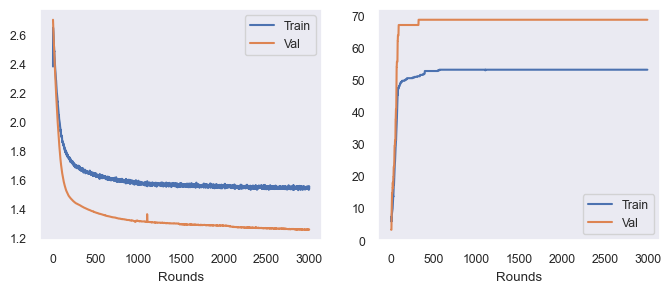

# ===== feat: 4 ===== #
[Epoch 0]  Train Loss: 2.3150515854358673  Train Acc: 7.93  Val Loss: 2.446648120880127  Train Acc: 1.64
[Epoch 500]  Train Loss: 1.6718556582927704  Train Acc: 52.24  Val Loss: 1.6948425769805908  Train Acc: 55.74
[Epoch 1000]  Train Loss: 1.5985079854726791  Train Acc: 53.66  Val Loss: 1.5753751993179321  Train Acc: 55.74
[Epoch 1500]  Train Loss: 1.5632494986057281  Train Acc: 53.66  Val Loss: 1.5390243530273438  Train Acc: 55.74
[Epoch 2000]  Train Loss: 1.556472972035408  Train Acc: 53.66  Val Loss: 1.529496192932129  Train Acc: 55.74
[Epoch 2500]  Train Loss: 1.5528927892446518  Train Acc: 53.66  Val Loss: 1.5286858081817627  Train Acc: 55.74
[Epoch 2999]  Train Loss: 1.5551755875349045  Train Acc: 53.66  Val Loss: 1.5296101570129395  Train Acc: 55.74


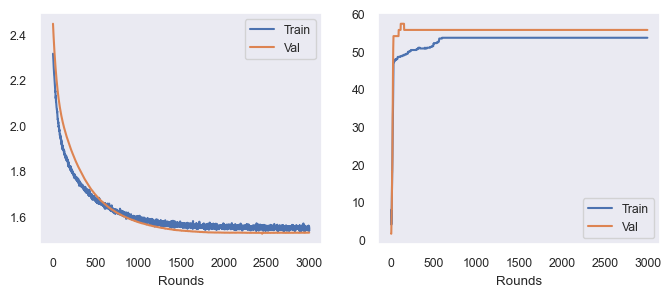

# ===== feat: 5 ===== #
[Epoch 0]  Train Loss: 2.2996133267879486  Train Acc: 19.11  Val Loss: 2.6204659938812256  Train Acc: 18.03
[Epoch 500]  Train Loss: 1.6696627736091614  Train Acc: 51.22  Val Loss: 2.104877471923828  Train Acc: 55.74
[Epoch 1000]  Train Loss: 1.563457876443863  Train Acc: 54.88  Val Loss: 2.0438179969787598  Train Acc: 62.30
[Epoch 1500]  Train Loss: 1.5069179832935333  Train Acc: 54.88  Val Loss: 2.0044422149658203  Train Acc: 62.30
[Epoch 2000]  Train Loss: 1.4848946779966354  Train Acc: 55.08  Val Loss: 2.1273093223571777  Train Acc: 62.30
[Epoch 2500]  Train Loss: 1.493187427520752  Train Acc: 54.88  Val Loss: 2.1926755905151367  Train Acc: 62.30
[Epoch 2999]  Train Loss: 1.485894039273262  Train Acc: 54.88  Val Loss: 2.2236876487731934  Train Acc: 62.30


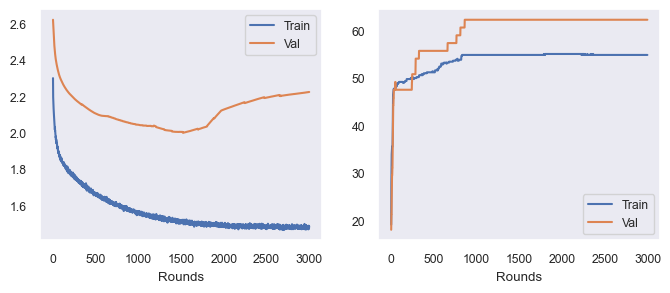

# ===== feat: 6 ===== #
[Epoch 0]  Train Loss: 2.3638631403446198  Train Acc: 19.11  Val Loss: 2.2590417861938477  Train Acc: 29.51
[Epoch 500]  Train Loss: 1.7036090642213821  Train Acc: 50.00  Val Loss: 1.6610838174819946  Train Acc: 54.10
[Epoch 1000]  Train Loss: 1.5899032056331635  Train Acc: 52.24  Val Loss: 1.5343159437179565  Train Acc: 59.02
[Epoch 1500]  Train Loss: 1.5456967502832413  Train Acc: 53.66  Val Loss: 1.453479528427124  Train Acc: 59.02
[Epoch 2000]  Train Loss: 1.5094903856515884  Train Acc: 53.86  Val Loss: 1.4302102327346802  Train Acc: 59.02
[Epoch 2500]  Train Loss: 1.50043423473835  Train Acc: 53.86  Val Loss: 1.472232460975647  Train Acc: 59.02
[Epoch 2999]  Train Loss: 1.488443911075592  Train Acc: 54.07  Val Loss: 1.5201400518417358  Train Acc: 59.02


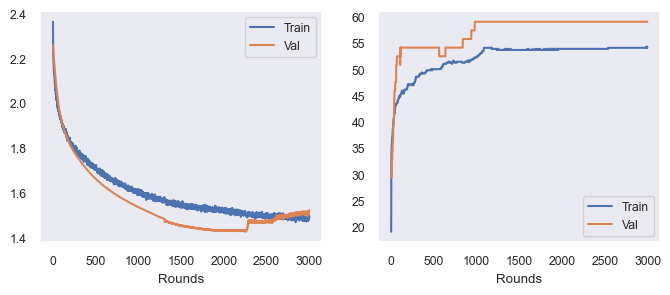

# ===== feat: 7 ===== #
[Epoch 0]  Train Loss: 2.519232898950577  Train Acc: 6.30  Val Loss: 2.5368709564208984  Train Acc: 6.56
[Epoch 500]  Train Loss: 1.65304334461689  Train Acc: 52.85  Val Loss: 1.9022881984710693  Train Acc: 47.54
[Epoch 1000]  Train Loss: 1.5457065850496292  Train Acc: 54.67  Val Loss: 1.7962820529937744  Train Acc: 54.10
[Epoch 1500]  Train Loss: 1.5041985660791397  Train Acc: 54.88  Val Loss: 1.7413771152496338  Train Acc: 54.10
[Epoch 2000]  Train Loss: 1.4686685353517532  Train Acc: 54.88  Val Loss: 1.7254085540771484  Train Acc: 54.10
[Epoch 2500]  Train Loss: 1.4505001157522202  Train Acc: 54.88  Val Loss: 1.7353018522262573  Train Acc: 52.46
[Epoch 2999]  Train Loss: 1.4279165714979172  Train Acc: 55.49  Val Loss: 1.7619599103927612  Train Acc: 52.46


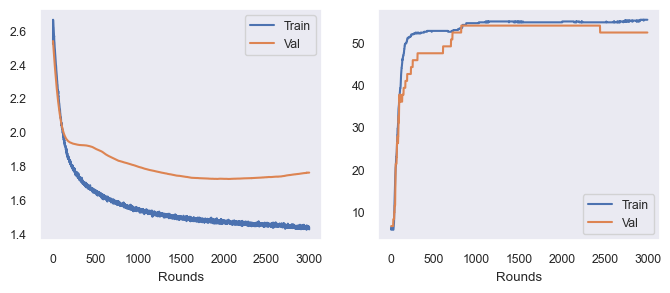

# ===== feat: 8 ===== #
[Epoch 0]  Train Loss: 2.4743916988372803  Train Acc: 9.15  Val Loss: 2.555112838745117  Train Acc: 1.64
[Epoch 500]  Train Loss: 1.595828428864479  Train Acc: 55.08  Val Loss: 1.886683702468872  Train Acc: 47.54
[Epoch 1000]  Train Loss: 1.5019921660423279  Train Acc: 56.50  Val Loss: 1.816784381866455  Train Acc: 47.54
[Epoch 1500]  Train Loss: 1.4672735035419464  Train Acc: 56.50  Val Loss: 1.8031367063522339  Train Acc: 47.54
[Epoch 2000]  Train Loss: 1.4491056352853775  Train Acc: 56.71  Val Loss: 1.8135638236999512  Train Acc: 47.54
[Epoch 2500]  Train Loss: 1.4278450161218643  Train Acc: 56.50  Val Loss: 1.8305567502975464  Train Acc: 47.54
[Epoch 2999]  Train Loss: 1.4374661594629288  Train Acc: 56.10  Val Loss: 1.8483026027679443  Train Acc: 47.54


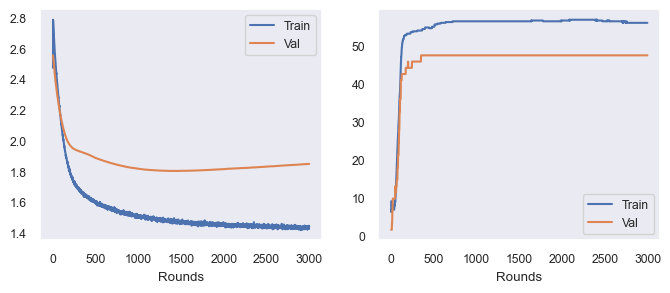

# ===== feat: 9 ===== #
[Epoch 0]  Train Loss: 2.4029043316841125  Train Acc: 12.20  Val Loss: 2.3702402114868164  Train Acc: 16.39
[Epoch 500]  Train Loss: 1.5923672765493393  Train Acc: 55.49  Val Loss: 1.786860466003418  Train Acc: 44.26
[Epoch 1000]  Train Loss: 1.501841515302658  Train Acc: 56.30  Val Loss: 1.7681463956832886  Train Acc: 45.90
[Epoch 1500]  Train Loss: 1.4697114080190659  Train Acc: 56.71  Val Loss: 1.7811634540557861  Train Acc: 45.90
[Epoch 2000]  Train Loss: 1.4432106018066406  Train Acc: 56.50  Val Loss: 1.8046077489852905  Train Acc: 45.90
[Epoch 2500]  Train Loss: 1.4177708327770233  Train Acc: 56.71  Val Loss: 1.8204269409179688  Train Acc: 45.90
[Epoch 2999]  Train Loss: 1.4131854325532913  Train Acc: 56.71  Val Loss: 1.8281558752059937  Train Acc: 45.90


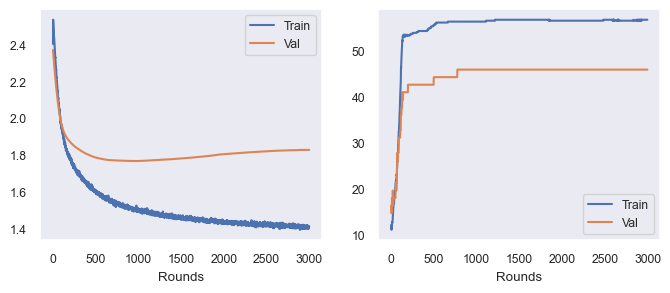

# ===== feat: 10 ===== #
[Epoch 0]  Train Loss: 2.5071753561496735  Train Acc: 10.98  Val Loss: 2.7912511825561523  Train Acc: 9.84
[Epoch 500]  Train Loss: 1.5782207548618317  Train Acc: 54.27  Val Loss: 1.6943531036376953  Train Acc: 50.82
[Epoch 1000]  Train Loss: 1.50924713909626  Train Acc: 55.08  Val Loss: 1.6763917207717896  Train Acc: 50.82
[Epoch 1500]  Train Loss: 1.4735851138830185  Train Acc: 55.08  Val Loss: 1.6801121234893799  Train Acc: 50.82
[Epoch 2000]  Train Loss: 1.4603445529937744  Train Acc: 55.28  Val Loss: 1.6925785541534424  Train Acc: 50.82
[Epoch 2500]  Train Loss: 1.4629245549440384  Train Acc: 55.49  Val Loss: 1.705854892730713  Train Acc: 50.82
[Epoch 2999]  Train Loss: 1.442469522356987  Train Acc: 55.49  Val Loss: 1.728056788444519  Train Acc: 50.82


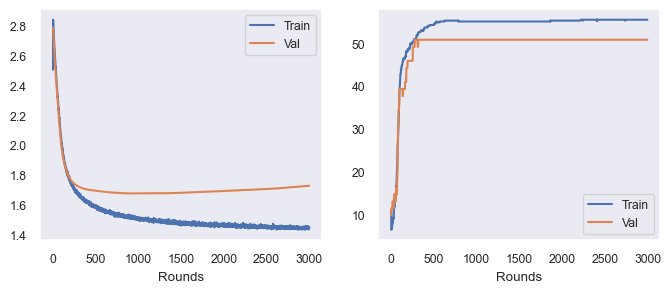

# ===== feat: 11 ===== #
[Epoch 0]  Train Loss: 2.4273018538951874  Train Acc: 7.11  Val Loss: 2.488431692123413  Train Acc: 6.56
[Epoch 500]  Train Loss: 1.6744495034217834  Train Acc: 49.80  Val Loss: 1.5624059438705444  Train Acc: 59.02
[Epoch 1000]  Train Loss: 1.5669802576303482  Train Acc: 52.03  Val Loss: 1.464140772819519  Train Acc: 62.30
[Epoch 1500]  Train Loss: 1.5242310017347336  Train Acc: 52.64  Val Loss: 1.4214835166931152  Train Acc: 63.93
[Epoch 2000]  Train Loss: 1.4880858212709427  Train Acc: 53.46  Val Loss: 1.3956987857818604  Train Acc: 63.93
[Epoch 2500]  Train Loss: 1.46786929666996  Train Acc: 53.46  Val Loss: 1.381641149520874  Train Acc: 63.93
[Epoch 2999]  Train Loss: 1.4448093622922897  Train Acc: 53.46  Val Loss: 1.3748148679733276  Train Acc: 63.93


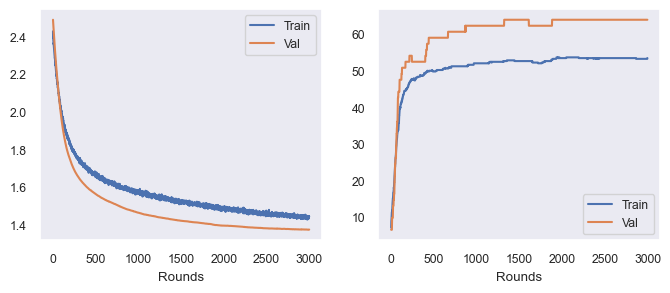

# ===== feat: 12 ===== #
[Epoch 0]  Train Loss: 2.610673874616623  Train Acc: 7.52  Val Loss: 2.6978492736816406  Train Acc: 13.11
[Epoch 500]  Train Loss: 1.6801710277795792  Train Acc: 52.24  Val Loss: 2.29158878326416  Train Acc: 54.10
[Epoch 1000]  Train Loss: 1.540477216243744  Train Acc: 54.07  Val Loss: 2.2693088054656982  Train Acc: 55.74
[Epoch 1500]  Train Loss: 1.4977914839982986  Train Acc: 54.88  Val Loss: 2.272048234939575  Train Acc: 55.74
[Epoch 2000]  Train Loss: 1.457411304116249  Train Acc: 55.08  Val Loss: 2.3140008449554443  Train Acc: 55.74
[Epoch 2500]  Train Loss: 1.4281436800956726  Train Acc: 54.88  Val Loss: 2.3207616806030273  Train Acc: 55.74
[Epoch 2999]  Train Loss: 1.4023118168115616  Train Acc: 55.28  Val Loss: 2.3208606243133545  Train Acc: 54.10


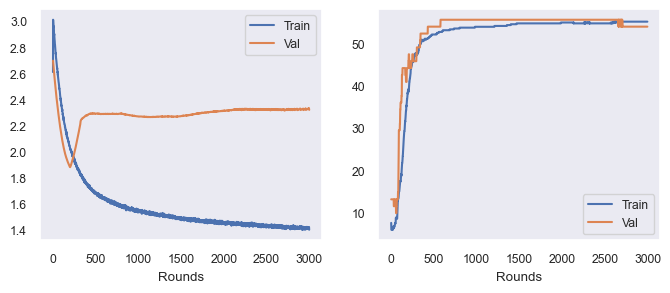

# ===== feat: 13 ===== #
[Epoch 0]  Train Loss: 2.46955344080925  Train Acc: 8.94  Val Loss: 3.003476142883301  Train Acc: 8.20
[Epoch 500]  Train Loss: 1.575165331363678  Train Acc: 55.69  Val Loss: 1.9514214992523193  Train Acc: 42.62
[Epoch 1000]  Train Loss: 1.464833214879036  Train Acc: 57.32  Val Loss: 1.9214015007019043  Train Acc: 47.54
[Epoch 1500]  Train Loss: 1.4087253361940384  Train Acc: 57.52  Val Loss: 1.9351537227630615  Train Acc: 45.90
[Epoch 2000]  Train Loss: 1.3880534023046494  Train Acc: 57.52  Val Loss: 1.954807996749878  Train Acc: 45.90
[Epoch 2500]  Train Loss: 1.3623393028974533  Train Acc: 57.52  Val Loss: 1.9697240591049194  Train Acc: 45.90
[Epoch 2999]  Train Loss: 1.357837900519371  Train Acc: 57.93  Val Loss: 1.9790680408477783  Train Acc: 45.90


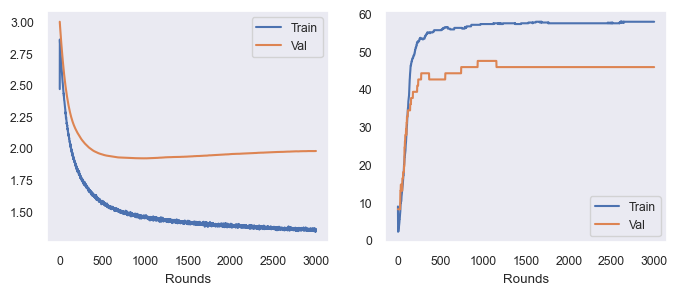

# ===== feat: 14 ===== #
[Epoch 0]  Train Loss: 2.378648579120636  Train Acc: 8.33  Val Loss: 2.26261830329895  Train Acc: 16.39
[Epoch 500]  Train Loss: 1.6293907314538956  Train Acc: 54.67  Val Loss: 1.7654266357421875  Train Acc: 55.74
[Epoch 1000]  Train Loss: 1.501015916466713  Train Acc: 56.10  Val Loss: 1.8264009952545166  Train Acc: 55.74
[Epoch 1500]  Train Loss: 1.4325033724308014  Train Acc: 56.30  Val Loss: 1.9275058507919312  Train Acc: 55.74
[Epoch 2000]  Train Loss: 1.3865569084882736  Train Acc: 56.71  Val Loss: 2.057366371154785  Train Acc: 55.74
[Epoch 2500]  Train Loss: 1.3498309701681137  Train Acc: 57.52  Val Loss: 2.1840476989746094  Train Acc: 55.74
[Epoch 2999]  Train Loss: 1.33480903506279  Train Acc: 57.32  Val Loss: 2.2565720081329346  Train Acc: 55.74


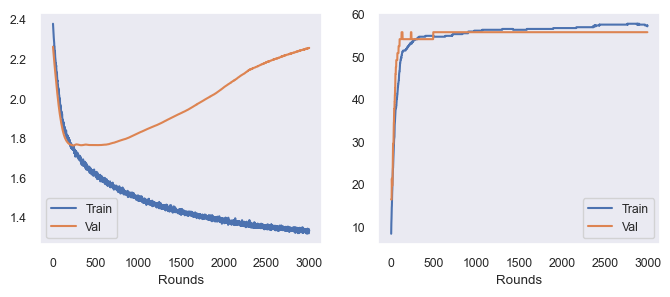

# ===== feat: 15 ===== #
[Epoch 0]  Train Loss: 2.3337025344371796  Train Acc: 13.21  Val Loss: 2.065202474594116  Train Acc: 26.23
[Epoch 500]  Train Loss: 1.588317185640335  Train Acc: 53.25  Val Loss: 1.6333266496658325  Train Acc: 54.10
[Epoch 1000]  Train Loss: 1.5160017907619476  Train Acc: 55.89  Val Loss: 1.6169157028198242  Train Acc: 54.10
[Epoch 1500]  Train Loss: 1.467659667134285  Train Acc: 56.71  Val Loss: 1.6298751831054688  Train Acc: 52.46
[Epoch 2000]  Train Loss: 1.4407209306955338  Train Acc: 56.50  Val Loss: 1.6535395383834839  Train Acc: 52.46
[Epoch 2500]  Train Loss: 1.4113883078098297  Train Acc: 56.50  Val Loss: 1.6737595796585083  Train Acc: 52.46
[Epoch 2999]  Train Loss: 1.3846661001443863  Train Acc: 56.30  Val Loss: 1.6856335401535034  Train Acc: 52.46


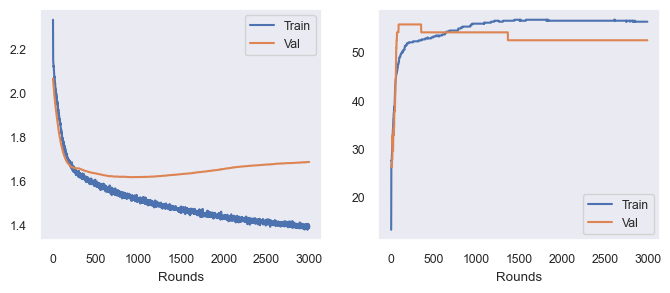

# ===== feat: 16 ===== #
[Epoch 0]  Train Loss: 2.561265528202057  Train Acc: 6.71  Val Loss: 2.6756529808044434  Train Acc: 9.84
[Epoch 500]  Train Loss: 1.6667404174804688  Train Acc: 49.39  Val Loss: 2.1018521785736084  Train Acc: 45.90
[Epoch 1000]  Train Loss: 1.548011064529419  Train Acc: 53.05  Val Loss: 1.9752658605575562  Train Acc: 47.54
[Epoch 1500]  Train Loss: 1.4892406314611435  Train Acc: 54.67  Val Loss: 1.9178496599197388  Train Acc: 45.90
[Epoch 2000]  Train Loss: 1.4558273553848267  Train Acc: 54.47  Val Loss: 1.884762167930603  Train Acc: 45.90
[Epoch 2500]  Train Loss: 1.4461932927370071  Train Acc: 55.08  Val Loss: 1.8661733865737915  Train Acc: 45.90
[Epoch 2999]  Train Loss: 1.4132973849773407  Train Acc: 55.28  Val Loss: 1.865721583366394  Train Acc: 45.90


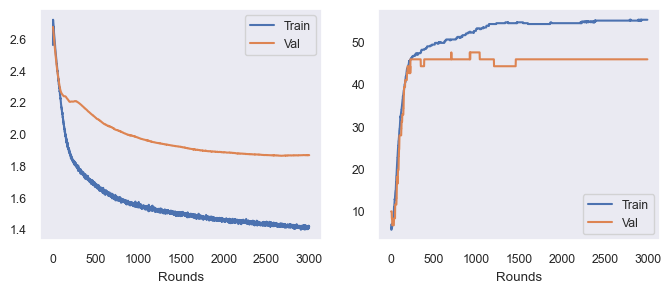

best set of exp0:  [68.85245901639345, 1.2574007334709167, 3, 0]


In [11]:
seed = 1228
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = 'exp1'

# ====== Model Capacity ====== #
args.in_dim = in_dim
args.out_dim = out_dim
args.hid_dim = 30
args.act = 'relu'
args.n_layer = 2

# ====== Regularization ======= #
args.dropout = 0.2
args.use_bn = True
args.l2 = 0.000001
args.use_xavier = True

# ====== Optimizer & Training ====== #
args.optim = 'Adam' 
args.lr = 1e-05

# ====== Federated Learning Parameters ====== #
args.epochs = 3000
args.train_batch_size = 64
args.test_batch_size = 64

args.feat = 0   #########################
#================================================================================#
name_var = 'feat'
list_var = np.arange(2, len(feature_idx))

exp0_best_set = [0, 100000, '', 0]

for var in list_var:
    setattr(args, name_var, var)
    setattr(args, 'in_dim', var)
    print(f'# ===== {name_var}: {var} ===== #')
    
    partition = make_dataset(feature_idx, sleep_data, survey_data, args)

    train_losses, val_losses, train_acces, val_acces = experiment(partition, args)
    plot_loss(train_losses, val_losses, train_acces, val_acces)

    mean_loss, mean_acc = np.mean(val_losses[-500:]), np.mean(val_acces[-500:])
    if mean_acc > exp0_best_set[0] and (mean_loss < exp0_best_set[1]):
        exp0_best_set[0], exp0_best_set[1], exp0_best_set[2] = mean_acc, mean_loss, var

print('best set of exp0: ', exp0_best_set)

#### **Ex1) *Optim vs lr***

# ===== optim: SGD ===== #
lr: 1e-06
[Epoch 0]  Train Loss: 2.4533655643463135  Train Acc: 15.45  Val Loss: 2.27695894241333  Train Acc: 4.92
[Epoch 500]  Train Loss: 2.1460626125335693  Train Acc: 51.63  Val Loss: 2.103137493133545  Train Acc: 57.38
[Epoch 1000]  Train Loss: 2.128209263086319  Train Acc: 51.63  Val Loss: 2.0794620513916016  Train Acc: 57.38
[Epoch 1500]  Train Loss: 2.1082939505577087  Train Acc: 51.42  Val Loss: 2.0498228073120117  Train Acc: 57.38
[Epoch 2000]  Train Loss: 2.0908001214265823  Train Acc: 51.02  Val Loss: 2.0279769897460938  Train Acc: 57.38
[Epoch 2500]  Train Loss: 2.082199215888977  Train Acc: 51.02  Val Loss: 2.0134780406951904  Train Acc: 57.38
[Epoch 2999]  Train Loss: 2.076588451862335  Train Acc: 51.02  Val Loss: 2.002859592437744  Train Acc: 57.38


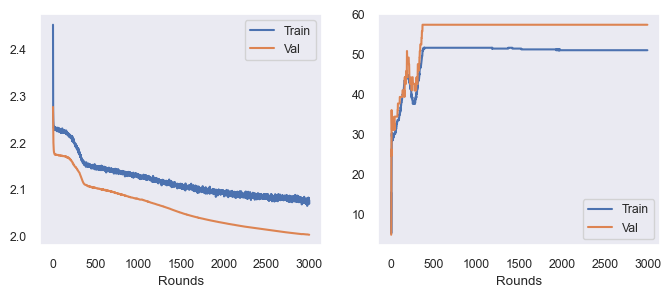

lr: 2.1544346900318822e-06
[Epoch 0]  Train Loss: 2.6137249171733856  Train Acc: 3.86  Val Loss: 2.621675491333008  Train Acc: 0.00
[Epoch 500]  Train Loss: 2.513564944267273  Train Acc: 2.44  Val Loss: 2.540300130844116  Train Acc: 1.64
[Epoch 1000]  Train Loss: 2.469929277896881  Train Acc: 2.85  Val Loss: 2.483691453933716  Train Acc: 1.64
[Epoch 1500]  Train Loss: 2.429768890142441  Train Acc: 2.85  Val Loss: 2.433887243270874  Train Acc: 1.64
[Epoch 2000]  Train Loss: 2.3921784162521362  Train Acc: 3.05  Val Loss: 2.3872318267822266  Train Acc: 3.28
[Epoch 2500]  Train Loss: 2.363188326358795  Train Acc: 3.25  Val Loss: 2.3512048721313477  Train Acc: 3.28
[Epoch 2999]  Train Loss: 2.33897602558136  Train Acc: 2.64  Val Loss: 2.321584463119507  Train Acc: 4.92


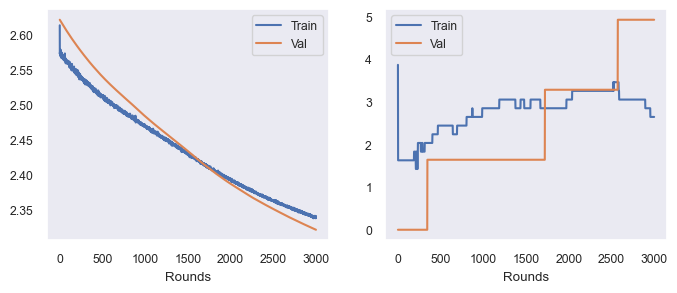

lr: 4.641588833612782e-06
[Epoch 0]  Train Loss: 2.384027123451233  Train Acc: 11.18  Val Loss: 2.2921125888824463  Train Acc: 4.92
[Epoch 500]  Train Loss: 2.1578418910503387  Train Acc: 38.82  Val Loss: 2.1247191429138184  Train Acc: 40.98
[Epoch 1000]  Train Loss: 2.105742961168289  Train Acc: 43.90  Val Loss: 2.0696449279785156  Train Acc: 44.26
[Epoch 1500]  Train Loss: 2.065607190132141  Train Acc: 45.12  Val Loss: 2.021562099456787  Train Acc: 45.90
[Epoch 2000]  Train Loss: 2.0276581048965454  Train Acc: 46.95  Val Loss: 1.9781274795532227  Train Acc: 45.90
[Epoch 2500]  Train Loss: 1.9823283404111862  Train Acc: 48.37  Val Loss: 1.939168930053711  Train Acc: 47.54
[Epoch 2999]  Train Loss: 1.9538904577493668  Train Acc: 49.59  Val Loss: 1.9065207242965698  Train Acc: 50.82


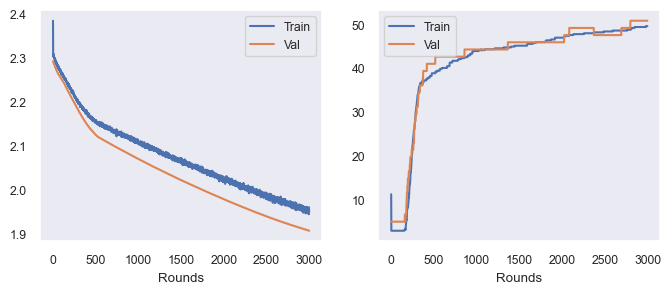

lr: 1e-05
[Epoch 0]  Train Loss: 2.519325226545334  Train Acc: 8.33  Val Loss: 2.4298810958862305  Train Acc: 6.56
[Epoch 500]  Train Loss: 1.9613231867551804  Train Acc: 52.64  Val Loss: 1.9290926456451416  Train Acc: 52.46
[Epoch 1000]  Train Loss: 1.80844846367836  Train Acc: 53.66  Val Loss: 1.7761896848678589  Train Acc: 54.10
[Epoch 1500]  Train Loss: 1.7441881746053696  Train Acc: 54.47  Val Loss: 1.7207707166671753  Train Acc: 55.74
[Epoch 2000]  Train Loss: 1.720019355416298  Train Acc: 54.47  Val Loss: 1.6803914308547974  Train Acc: 55.74
[Epoch 2500]  Train Loss: 1.6880848407745361  Train Acc: 54.47  Val Loss: 1.6484578847885132  Train Acc: 55.74
[Epoch 2999]  Train Loss: 1.6603740602731705  Train Acc: 54.47  Val Loss: 1.6172335147857666  Train Acc: 55.74


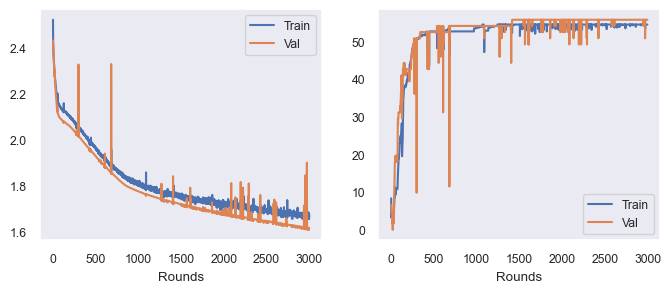

lr: 2.1544346900318823e-05
[Epoch 0]  Train Loss: 2.367145001888275  Train Acc: 16.06  Val Loss: 2.2724132537841797  Train Acc: 16.39
[Epoch 500]  Train Loss: 1.8274639695882797  Train Acc: 52.64  Val Loss: 1.873024582862854  Train Acc: 45.90
[Epoch 1000]  Train Loss: 1.7650447934865952  Train Acc: 52.85  Val Loss: 1.858526587486267  Train Acc: 45.90
[Epoch 1500]  Train Loss: 1.736365094780922  Train Acc: 53.05  Val Loss: 1.8475399017333984  Train Acc: 45.90
[Epoch 2000]  Train Loss: 1.7032737731933594  Train Acc: 53.86  Val Loss: 1.8243030309677124  Train Acc: 45.90
[Epoch 2500]  Train Loss: 1.6778339445590973  Train Acc: 54.88  Val Loss: 1.7989012002944946  Train Acc: 47.54
[Epoch 2999]  Train Loss: 1.669082134962082  Train Acc: 55.08  Val Loss: 1.7735008001327515  Train Acc: 47.54


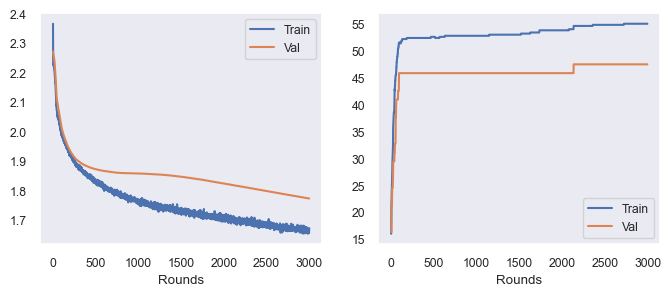

lr: 4.641588833612772e-05
[Epoch 0]  Train Loss: 2.4196203649044037  Train Acc: 8.74  Val Loss: 2.309077739715576  Train Acc: 8.20
[Epoch 500]  Train Loss: 1.7206268310546875  Train Acc: 52.03  Val Loss: 1.9132167100906372  Train Acc: 52.46
[Epoch 1000]  Train Loss: 1.6709299832582474  Train Acc: 53.05  Val Loss: 1.8773596286773682  Train Acc: 54.10
[Epoch 1500]  Train Loss: 1.6537584513425827  Train Acc: 54.47  Val Loss: 1.8496222496032715  Train Acc: 57.38
[Epoch 2000]  Train Loss: 1.6340931057929993  Train Acc: 54.47  Val Loss: 1.8274877071380615  Train Acc: 57.38
[Epoch 2500]  Train Loss: 1.6332916766405106  Train Acc: 54.47  Val Loss: 1.8033019304275513  Train Acc: 57.38
[Epoch 2999]  Train Loss: 1.6092558205127716  Train Acc: 54.47  Val Loss: 1.7813907861709595  Train Acc: 57.38


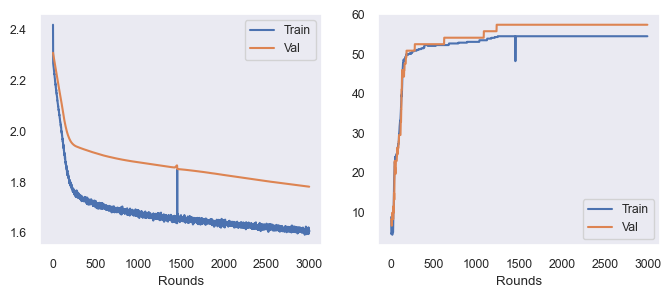

lr: 0.0001
[Epoch 0]  Train Loss: 2.553740382194519  Train Acc: 7.11  Val Loss: 2.3735287189483643  Train Acc: 11.48
[Epoch 500]  Train Loss: 1.7799577862024307  Train Acc: 50.20  Val Loss: 1.8249903917312622  Train Acc: 49.18
[Epoch 1000]  Train Loss: 1.665748804807663  Train Acc: 53.25  Val Loss: 1.6950017213821411  Train Acc: 50.82
[Epoch 1500]  Train Loss: 1.6014477163553238  Train Acc: 54.67  Val Loss: 1.6123046875  Train Acc: 54.10
[Epoch 2000]  Train Loss: 1.554763913154602  Train Acc: 54.67  Val Loss: 1.5683492422103882  Train Acc: 54.10
[Epoch 2500]  Train Loss: 1.5685380697250366  Train Acc: 54.67  Val Loss: 1.548478364944458  Train Acc: 54.10
[Epoch 2999]  Train Loss: 1.555623635649681  Train Acc: 54.67  Val Loss: 1.5398138761520386  Train Acc: 54.10


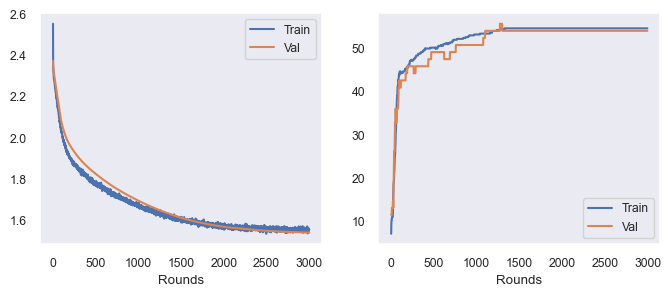

# ===== optim: RMSprop ===== #
lr: 1e-06
[Epoch 0]  Train Loss: 2.438944309949875  Train Acc: 13.21  Val Loss: 2.379983425140381  Train Acc: 9.84
[Epoch 500]  Train Loss: 2.299655705690384  Train Acc: 10.57  Val Loss: 2.300161600112915  Train Acc: 8.20
[Epoch 1000]  Train Loss: 2.199967384338379  Train Acc: 14.43  Val Loss: 2.228785753250122  Train Acc: 11.48
[Epoch 1500]  Train Loss: 2.130786955356598  Train Acc: 36.59  Val Loss: 2.178356170654297  Train Acc: 29.51
[Epoch 2000]  Train Loss: 2.080139011144638  Train Acc: 44.11  Val Loss: 2.1415205001831055  Train Acc: 36.07
[Epoch 2500]  Train Loss: 2.0275549441576004  Train Acc: 51.22  Val Loss: 2.1056132316589355  Train Acc: 39.34
[Epoch 2999]  Train Loss: 1.8967120796442032  Train Acc: 54.07  Val Loss: 1.9832069873809814  Train Acc: 42.62


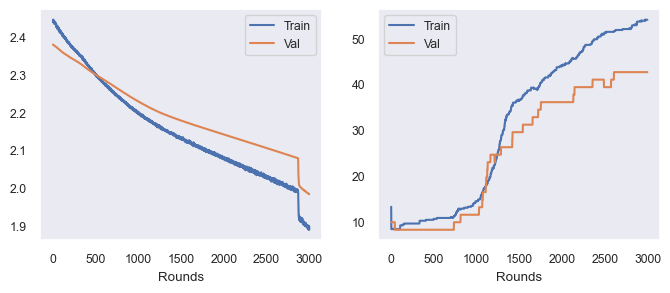

lr: 2.1544346900318822e-06
[Epoch 0]  Train Loss: 2.429076671600342  Train Acc: 16.46  Val Loss: 2.7710683345794678  Train Acc: 4.92
[Epoch 500]  Train Loss: 2.1675054132938385  Train Acc: 30.28  Val Loss: 2.2929227352142334  Train Acc: 21.31
[Epoch 1000]  Train Loss: 2.1017721593379974  Train Acc: 40.45  Val Loss: 2.214601993560791  Train Acc: 37.70
[Epoch 1500]  Train Loss: 2.0386509001255035  Train Acc: 48.98  Val Loss: 2.180206775665283  Train Acc: 45.90
[Epoch 2000]  Train Loss: 1.9559058248996735  Train Acc: 53.66  Val Loss: 2.141594648361206  Train Acc: 47.54
[Epoch 2500]  Train Loss: 1.8825803250074387  Train Acc: 55.28  Val Loss: 2.1074655055999756  Train Acc: 50.82
[Epoch 2999]  Train Loss: 1.8054535239934921  Train Acc: 55.89  Val Loss: 2.0691027641296387  Train Acc: 50.82


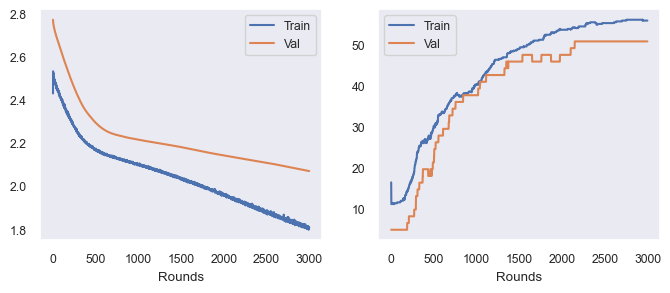

lr: 4.641588833612782e-06
[Epoch 0]  Train Loss: 2.479791820049286  Train Acc: 11.38  Val Loss: 2.372018814086914  Train Acc: 4.92
[Epoch 500]  Train Loss: 1.9451259821653366  Train Acc: 51.63  Val Loss: 1.9328376054763794  Train Acc: 47.54
[Epoch 1000]  Train Loss: 1.730041190981865  Train Acc: 52.44  Val Loss: 1.734126091003418  Train Acc: 50.82
[Epoch 1500]  Train Loss: 1.6414531469345093  Train Acc: 54.27  Val Loss: 1.684983730316162  Train Acc: 52.46
[Epoch 2000]  Train Loss: 1.5971481949090958  Train Acc: 54.67  Val Loss: 1.6621707677841187  Train Acc: 54.10
[Epoch 2500]  Train Loss: 1.5610380470752716  Train Acc: 54.47  Val Loss: 1.6535974740982056  Train Acc: 54.10
[Epoch 2999]  Train Loss: 1.5512982159852982  Train Acc: 54.47  Val Loss: 1.6488428115844727  Train Acc: 54.10


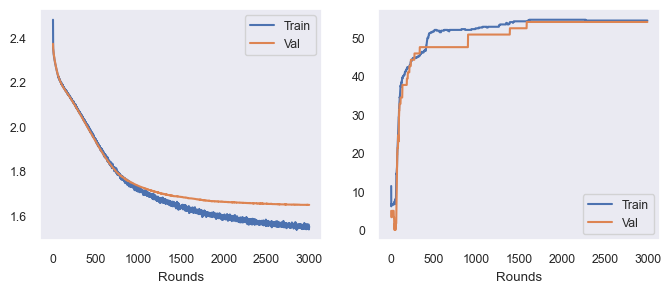

lr: 1e-05
[Epoch 0]  Train Loss: 2.3832627832889557  Train Acc: 20.53  Val Loss: 2.2469122409820557  Train Acc: 24.59
[Epoch 500]  Train Loss: 1.7434407472610474  Train Acc: 54.47  Val Loss: 1.8972058296203613  Train Acc: 47.54
[Epoch 1000]  Train Loss: 1.62429079413414  Train Acc: 54.47  Val Loss: 1.712555170059204  Train Acc: 47.54
[Epoch 1500]  Train Loss: 1.5829205513000488  Train Acc: 54.47  Val Loss: 1.6183925867080688  Train Acc: 47.54
[Epoch 2000]  Train Loss: 1.5633948892354965  Train Acc: 54.47  Val Loss: 1.5869170427322388  Train Acc: 47.54
[Epoch 2500]  Train Loss: 1.5606438368558884  Train Acc: 54.47  Val Loss: 1.577284574508667  Train Acc: 47.54
[Epoch 2999]  Train Loss: 1.5537485182285309  Train Acc: 54.47  Val Loss: 1.5731812715530396  Train Acc: 47.54


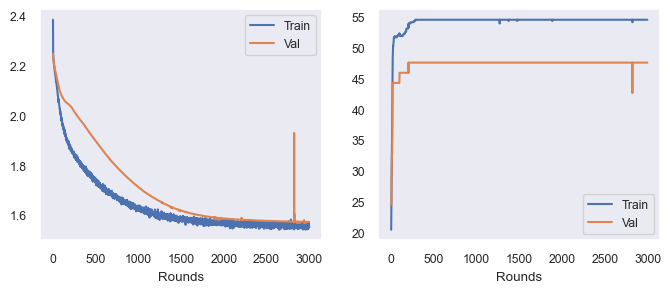

lr: 2.1544346900318823e-05
[Epoch 0]  Train Loss: 2.481571078300476  Train Acc: 7.52  Val Loss: 2.438284158706665  Train Acc: 4.92
[Epoch 500]  Train Loss: 1.576471671462059  Train Acc: 55.28  Val Loss: 1.6826533079147339  Train Acc: 50.82
[Epoch 1000]  Train Loss: 1.5238337516784668  Train Acc: 55.28  Val Loss: 1.646832823753357  Train Acc: 50.82
[Epoch 1500]  Train Loss: 1.5096836984157562  Train Acc: 55.28  Val Loss: 1.6444764137268066  Train Acc: 50.82
[Epoch 2000]  Train Loss: 1.497732788324356  Train Acc: 55.28  Val Loss: 1.6492503881454468  Train Acc: 50.82


In [13]:
seed = 1228
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = 'exp1'

# ====== Model Capacity ====== #
args.in_dim = exp0_best_set[2]
args.out_dim = out_dim
args.hid_dim = 15
args.act = 'relu'
args.n_layer = 4

# ====== Regularization ======= #
args.dropout = 0.2
args.use_bn = True
args.l2 = 0.000001
args.use_xavier = True

# ====== Optimizer & Training ====== #
args.optim = '' #########################
args.lr = 0     #########################

# ====== Federated Learning Parameters ====== #
args.epochs = 3000
args.train_batch_size = 64
args.test_batch_size = 64

args.feat = exp0_best_set[2]
#================================================================================#
name_var1 = 'optim'
name_var2 = 'lr'
list_var1 = ['SGD', 'RMSprop', 'Adam']
list_var2 = np.logspace(-6, -4, 7)

exp1_best_set = [0, 100000, '', 0]

partition = make_dataset(feature_idx, sleep_data, survey_data, args)

for var1 in list_var1:
    setattr(args, name_var1, var1)
    print(f'# ===== {name_var1}: {var1} ===== #')

    for var2 in list_var2:
        setattr(args, name_var2, var2)
        print(f'{name_var2}: {var2}')

        partition = make_dataset(feature_idx, sleep_data, survey_data, args)
    
        train_losses, val_losses, train_acces, val_acces = experiment(partition, args)
        plot_loss(train_losses, val_losses, train_acces, val_acces)

        mean_loss, mean_acc = np.mean(val_losses[-500:]), np.mean(val_acces[-500:])
        if mean_acc > exp1_best_set[0] and (mean_loss < exp1_best_set[1]):
            exp1_best_set[0], exp1_best_set[1], exp1_best_set[2], exp1_best_set[3] = mean_acc, mean_loss, var1, var2

print('best set of exp1: ', exp1_best_set)

#### **Ex2) *hid_dim vs n_layer***

# ===== hid_dim: 5 ===== #
n_layer: 1
[Epoch 0]  Train Loss: 84.63591378927231  Train Acc: 5.89  Val Loss: 2.7281596660614014  Train Acc: 9.84
[Epoch 500]  Train Loss: 2.196416437625885  Train Acc: 3.86  Val Loss: 2.1561336517333984  Train Acc: 9.84
[Epoch 1000]  Train Loss: 2.1591350734233856  Train Acc: 53.46  Val Loss: 2.1228785514831543  Train Acc: 50.82
[Epoch 1500]  Train Loss: 2.1244241893291473  Train Acc: 53.46  Val Loss: 2.091317892074585  Train Acc: 50.82
[Epoch 2000]  Train Loss: 2.088789403438568  Train Acc: 53.86  Val Loss: 2.0614118576049805  Train Acc: 50.82
[Epoch 2500]  Train Loss: 2.0543733835220337  Train Acc: 53.86  Val Loss: 2.033238410949707  Train Acc: 50.82
[Epoch 2999]  Train Loss: 2.025763377547264  Train Acc: 53.86  Val Loss: 2.0067830085754395  Train Acc: 50.82


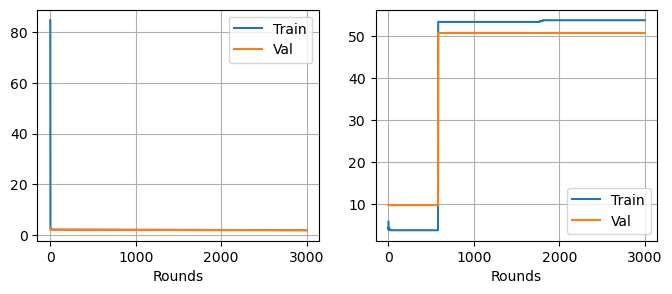

n_layer: 2
[Epoch 0]  Train Loss: 2.3358852565288544  Train Acc: 5.89  Val Loss: 2.6820099353790283  Train Acc: 4.92
[Epoch 500]  Train Loss: 2.209827959537506  Train Acc: 20.53  Val Loss: 2.3118722438812256  Train Acc: 11.48
[Epoch 1000]  Train Loss: 2.1544728577136993  Train Acc: 29.07  Val Loss: 2.2536001205444336  Train Acc: 13.11
[Epoch 1500]  Train Loss: 2.0932527482509613  Train Acc: 38.21  Val Loss: 2.19657301902771  Train Acc: 31.15
[Epoch 2000]  Train Loss: 2.0291706174612045  Train Acc: 45.33  Val Loss: 2.120652198791504  Train Acc: 42.62
[Epoch 2500]  Train Loss: 1.9440687447786331  Train Acc: 50.00  Val Loss: 2.0476338863372803  Train Acc: 47.54
[Epoch 2999]  Train Loss: 1.8452305644750595  Train Acc: 51.02  Val Loss: 1.976362943649292  Train Acc: 47.54


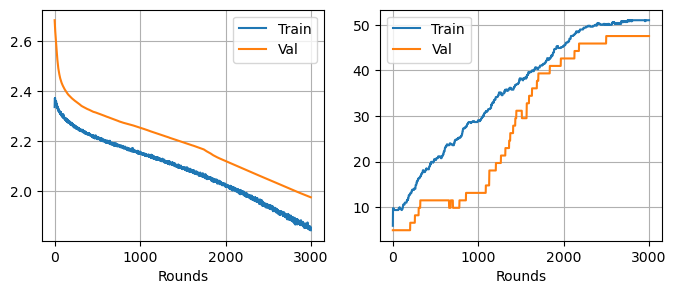

n_layer: 3
[Epoch 0]  Train Loss: 2.41363725066185  Train Acc: 12.20  Val Loss: 2.4233245849609375  Train Acc: 4.92
[Epoch 500]  Train Loss: 2.129003554582596  Train Acc: 8.94  Val Loss: 2.1158435344696045  Train Acc: 11.48
[Epoch 1000]  Train Loss: 2.0574880242347717  Train Acc: 45.93  Val Loss: 2.0526340007781982  Train Acc: 42.62
[Epoch 1500]  Train Loss: 2.0005237013101578  Train Acc: 49.59  Val Loss: 1.9960719347000122  Train Acc: 49.18
[Epoch 2000]  Train Loss: 1.9442217499017715  Train Acc: 51.42  Val Loss: 1.9469197988510132  Train Acc: 52.46
[Epoch 2500]  Train Loss: 1.8987649381160736  Train Acc: 53.66  Val Loss: 1.9021483659744263  Train Acc: 50.82
[Epoch 2999]  Train Loss: 1.8408357053995132  Train Acc: 53.66  Val Loss: 1.8614094257354736  Train Acc: 50.82


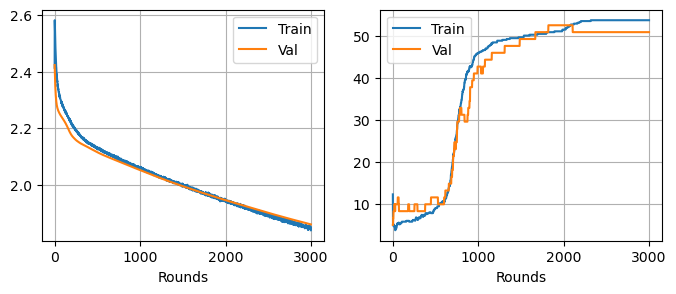

n_layer: 4
[Epoch 0]  Train Loss: 2.64514297246933  Train Acc: 6.30  Val Loss: 2.920804500579834  Train Acc: 1.64
[Epoch 500]  Train Loss: 2.3913536369800568  Train Acc: 5.08  Val Loss: 2.407989501953125  Train Acc: 3.28
[Epoch 1000]  Train Loss: 2.2448348701000214  Train Acc: 5.49  Val Loss: 2.272467851638794  Train Acc: 3.28
[Epoch 1500]  Train Loss: 2.0896513760089874  Train Acc: 49.80  Val Loss: 2.1302175521850586  Train Acc: 44.26
[Epoch 2000]  Train Loss: 1.9296873062849045  Train Acc: 52.44  Val Loss: 1.9919838905334473  Train Acc: 47.54
[Epoch 2500]  Train Loss: 1.794785976409912  Train Acc: 52.85  Val Loss: 1.8742291927337646  Train Acc: 49.18
[Epoch 2999]  Train Loss: 1.7041231095790863  Train Acc: 53.46  Val Loss: 1.7997517585754395  Train Acc: 49.18


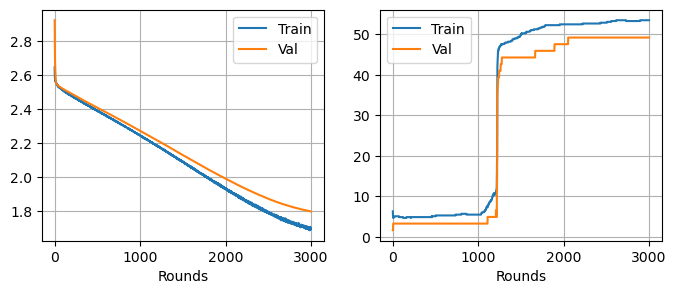

n_layer: 5
[Epoch 0]  Train Loss: 2.3412298560142517  Train Acc: 11.99  Val Loss: 2.1878457069396973  Train Acc: 24.59
[Epoch 500]  Train Loss: 2.12488654255867  Train Acc: 45.93  Val Loss: 2.1312808990478516  Train Acc: 47.54
[Epoch 1000]  Train Loss: 2.0633920282125473  Train Acc: 51.42  Val Loss: 2.0822231769561768  Train Acc: 49.18
[Epoch 1500]  Train Loss: 2.014295771718025  Train Acc: 52.85  Val Loss: 2.0377345085144043  Train Acc: 50.82
[Epoch 2000]  Train Loss: 1.962542086839676  Train Acc: 53.46  Val Loss: 1.998963475227356  Train Acc: 50.82
[Epoch 2500]  Train Loss: 1.9124160557985306  Train Acc: 53.86  Val Loss: 1.9615790843963623  Train Acc: 50.82
[Epoch 2999]  Train Loss: 1.8700264543294907  Train Acc: 53.86  Val Loss: 1.926742672920227  Train Acc: 50.82


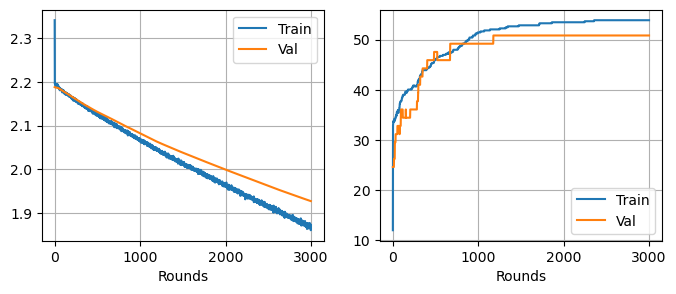

# ===== hid_dim: 15 ===== #
n_layer: 1
[Epoch 0]  Train Loss: 422.9192237854004  Train Acc: 32.72  Val Loss: 167.00204467773438  Train Acc: 34.43
[Epoch 500]  Train Loss: 2.1817303597927094  Train Acc: 5.08  Val Loss: 5.229608535766602  Train Acc: 1.64
[Epoch 1000]  Train Loss: 2.120567202568054  Train Acc: 6.50  Val Loss: 5.211984634399414  Train Acc: 3.28
[Epoch 1500]  Train Loss: 2.0844672471284866  Train Acc: 54.88  Val Loss: 5.286840915679932  Train Acc: 49.18
[Epoch 2000]  Train Loss: 2.0491169691085815  Train Acc: 54.47  Val Loss: 5.311502933502197  Train Acc: 49.18
[Epoch 2500]  Train Loss: 2.02169468998909  Train Acc: 54.67  Val Loss: 5.361268043518066  Train Acc: 49.18
[Epoch 2999]  Train Loss: 1.9872198551893234  Train Acc: 54.88  Val Loss: 5.362916946411133  Train Acc: 49.18


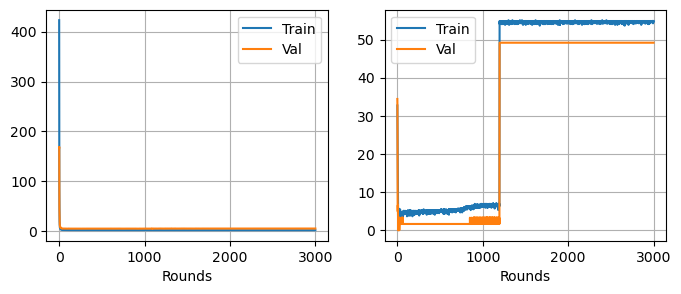

n_layer: 2
[Epoch 0]  Train Loss: 2.360632210969925  Train Acc: 13.41  Val Loss: 2.313209056854248  Train Acc: 22.95
[Epoch 500]  Train Loss: 1.715283289551735  Train Acc: 53.25  Val Loss: 1.928588628768921  Train Acc: 47.54
[Epoch 1000]  Train Loss: 1.6593489199876785  Train Acc: 53.86  Val Loss: 1.9045361280441284  Train Acc: 47.54
[Epoch 1500]  Train Loss: 1.6395911276340485  Train Acc: 54.07  Val Loss: 1.8798022270202637  Train Acc: 47.54
[Epoch 2000]  Train Loss: 1.608419269323349  Train Acc: 54.07  Val Loss: 1.8501832485198975  Train Acc: 47.54
[Epoch 2500]  Train Loss: 1.5996544808149338  Train Acc: 54.07  Val Loss: 1.8209880590438843  Train Acc: 49.18
[Epoch 2999]  Train Loss: 1.5971269607543945  Train Acc: 54.27  Val Loss: 1.7962576150894165  Train Acc: 49.18


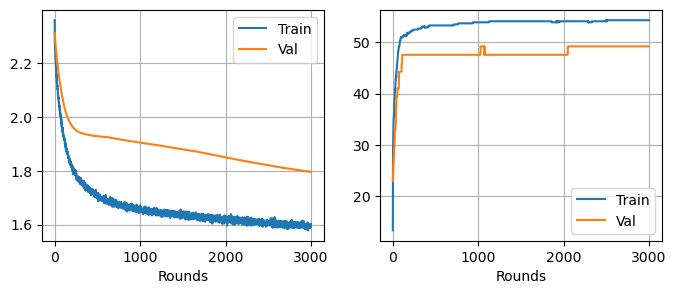

n_layer: 3
[Epoch 0]  Train Loss: 2.4152251183986664  Train Acc: 8.13  Val Loss: 2.422776699066162  Train Acc: 3.28
[Epoch 500]  Train Loss: 1.9995743334293365  Train Acc: 44.92  Val Loss: 2.0061609745025635  Train Acc: 40.98
[Epoch 1000]  Train Loss: 1.7535454630851746  Train Acc: 50.20  Val Loss: 1.8313345909118652  Train Acc: 44.26
[Epoch 1500]  Train Loss: 1.653819426894188  Train Acc: 51.63  Val Loss: 1.7653220891952515  Train Acc: 49.18
[Epoch 2000]  Train Loss: 1.6120714396238327  Train Acc: 52.24  Val Loss: 1.716773509979248  Train Acc: 49.18
[Epoch 2500]  Train Loss: 1.6040050685405731  Train Acc: 53.66  Val Loss: 1.6925671100616455  Train Acc: 47.54
[Epoch 2999]  Train Loss: 1.5960971266031265  Train Acc: 53.86  Val Loss: 1.6810364723205566  Train Acc: 47.54


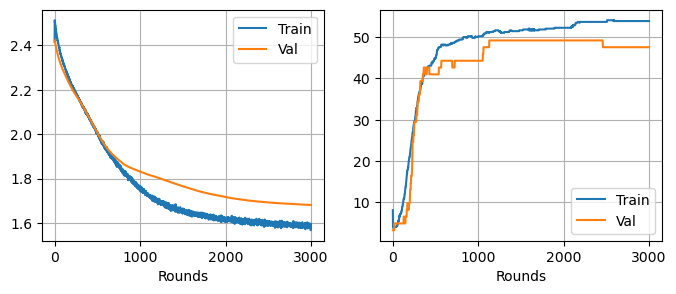

n_layer: 4
[Epoch 0]  Train Loss: 2.6145654022693634  Train Acc: 7.11  Val Loss: 2.491752862930298  Train Acc: 1.64
[Epoch 500]  Train Loss: 2.273415356874466  Train Acc: 8.33  Val Loss: 2.293016195297241  Train Acc: 1.64
[Epoch 1000]  Train Loss: 1.889974907040596  Train Acc: 51.42  Val Loss: 1.9615901708602905  Train Acc: 42.62
[Epoch 1500]  Train Loss: 1.7500417679548264  Train Acc: 52.44  Val Loss: 1.8452367782592773  Train Acc: 42.62
[Epoch 2000]  Train Loss: 1.694470375776291  Train Acc: 52.85  Val Loss: 1.7927684783935547  Train Acc: 44.26
[Epoch 2500]  Train Loss: 1.6467583179473877  Train Acc: 52.85  Val Loss: 1.7579330205917358  Train Acc: 44.26
[Epoch 2999]  Train Loss: 1.6369470804929733  Train Acc: 52.85  Val Loss: 1.7435356378555298  Train Acc: 44.26


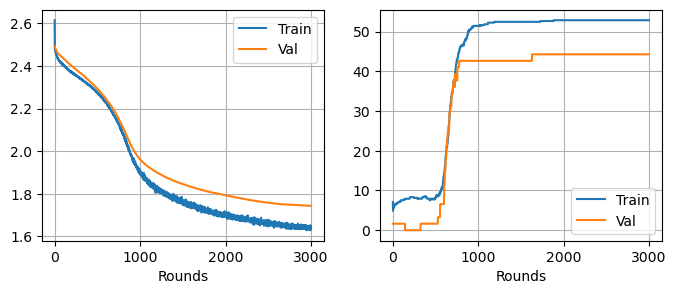

n_layer: 5
[Epoch 0]  Train Loss: 2.509302496910095  Train Acc: 4.88  Val Loss: 2.4985432624816895  Train Acc: 1.64
[Epoch 500]  Train Loss: 2.247884899377823  Train Acc: 10.98  Val Loss: 2.2938249111175537  Train Acc: 0.00
[Epoch 1000]  Train Loss: 1.6631102114915848  Train Acc: 51.83  Val Loss: 1.8770968914031982  Train Acc: 47.54
[Epoch 1500]  Train Loss: 1.586491659283638  Train Acc: 53.25  Val Loss: 1.8465006351470947  Train Acc: 47.54
[Epoch 2000]  Train Loss: 1.5712229162454605  Train Acc: 53.25  Val Loss: 1.8212541341781616  Train Acc: 47.54
[Epoch 2500]  Train Loss: 1.5519410967826843  Train Acc: 53.25  Val Loss: 1.8094466924667358  Train Acc: 47.54
[Epoch 2999]  Train Loss: 1.5384870022535324  Train Acc: 53.66  Val Loss: 1.805246353149414  Train Acc: 47.54


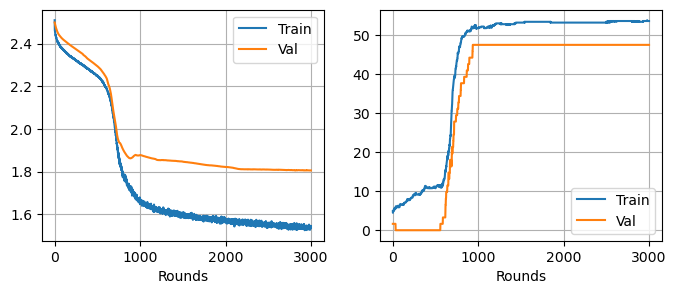

# ===== hid_dim: 50 ===== #
n_layer: 1
[Epoch 0]  Train Loss: 822.9355659484863  Train Acc: 33.13  Val Loss: 651.5159301757812  Train Acc: 8.20
[Epoch 500]  Train Loss: 1.1434577256441116  Train Acc: 64.63  Val Loss: 10.794622421264648  Train Acc: 37.70
[Epoch 1000]  Train Loss: 1.0538065433502197  Train Acc: 66.87  Val Loss: 10.753473281860352  Train Acc: 45.90
[Epoch 1500]  Train Loss: 0.9645826295018196  Train Acc: 70.33  Val Loss: 10.868882179260254  Train Acc: 44.26
[Epoch 2000]  Train Loss: 0.9878197386860847  Train Acc: 68.90  Val Loss: 11.218001365661621  Train Acc: 40.98
[Epoch 2500]  Train Loss: 0.9249484315514565  Train Acc: 70.73  Val Loss: 11.526841163635254  Train Acc: 39.34
[Epoch 2999]  Train Loss: 0.9189690575003624  Train Acc: 70.93  Val Loss: 11.697198867797852  Train Acc: 39.34


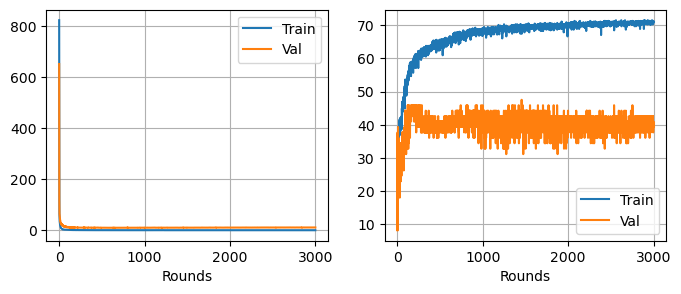

n_layer: 2
[Epoch 0]  Train Loss: 2.46011158823967  Train Acc: 7.11  Val Loss: 2.659876585006714  Train Acc: 6.56
[Epoch 500]  Train Loss: 1.6649646162986755  Train Acc: 52.85  Val Loss: 1.7996996641159058  Train Acc: 42.62
[Epoch 1000]  Train Loss: 1.5769668370485306  Train Acc: 53.46  Val Loss: 1.743062138557434  Train Acc: 47.54
[Epoch 1500]  Train Loss: 1.5234607458114624  Train Acc: 54.07  Val Loss: 1.7220053672790527  Train Acc: 47.54
[Epoch 2000]  Train Loss: 1.488425150513649  Train Acc: 54.47  Val Loss: 1.7152529954910278  Train Acc: 49.18
[Epoch 2500]  Train Loss: 1.4847024828195572  Train Acc: 54.67  Val Loss: 1.7111451625823975  Train Acc: 49.18
[Epoch 2999]  Train Loss: 1.447457417845726  Train Acc: 54.47  Val Loss: 1.7079095840454102  Train Acc: 49.18


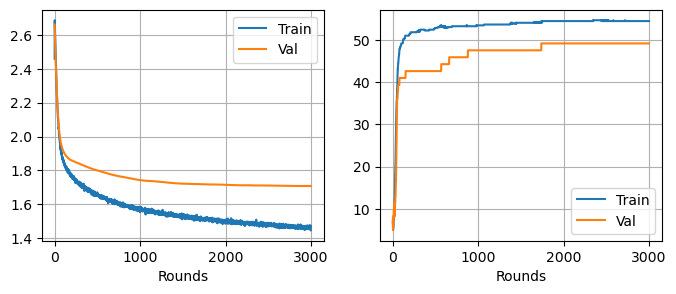

n_layer: 3
[Epoch 0]  Train Loss: 2.4868150651454926  Train Acc: 12.80  Val Loss: 2.6165449619293213  Train Acc: 4.92
[Epoch 500]  Train Loss: 1.5931618809700012  Train Acc: 52.03  Val Loss: 1.7291345596313477  Train Acc: 44.26
[Epoch 1000]  Train Loss: 1.5393188297748566  Train Acc: 53.05  Val Loss: 1.6918878555297852  Train Acc: 49.18
[Epoch 1500]  Train Loss: 1.509060949087143  Train Acc: 53.05  Val Loss: 1.6804826259613037  Train Acc: 49.18
[Epoch 2000]  Train Loss: 1.5009601265192032  Train Acc: 53.05  Val Loss: 1.673249363899231  Train Acc: 49.18
[Epoch 2500]  Train Loss: 1.4747304171323776  Train Acc: 54.47  Val Loss: 1.6721910238265991  Train Acc: 49.18
[Epoch 2999]  Train Loss: 1.4734597653150558  Train Acc: 54.47  Val Loss: 1.672992467880249  Train Acc: 49.18


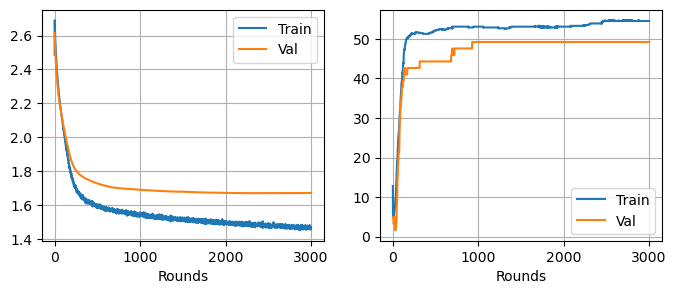

n_layer: 4
[Epoch 0]  Train Loss: 2.4704509377479553  Train Acc: 14.43  Val Loss: 2.4793128967285156  Train Acc: 16.39
[Epoch 500]  Train Loss: 1.6552691757678986  Train Acc: 52.24  Val Loss: 1.9915375709533691  Train Acc: 49.18
[Epoch 1000]  Train Loss: 1.586071401834488  Train Acc: 53.25  Val Loss: 1.9899234771728516  Train Acc: 49.18
[Epoch 1500]  Train Loss: 1.5511961430311203  Train Acc: 54.27  Val Loss: 1.9741230010986328  Train Acc: 50.82
[Epoch 2000]  Train Loss: 1.5125074088573456  Train Acc: 54.47  Val Loss: 1.9674195051193237  Train Acc: 50.82
[Epoch 2500]  Train Loss: 1.484617918729782  Train Acc: 54.67  Val Loss: 1.9699560403823853  Train Acc: 50.82
[Epoch 2999]  Train Loss: 1.4749277234077454  Train Acc: 54.67  Val Loss: 1.981870412826538  Train Acc: 50.82


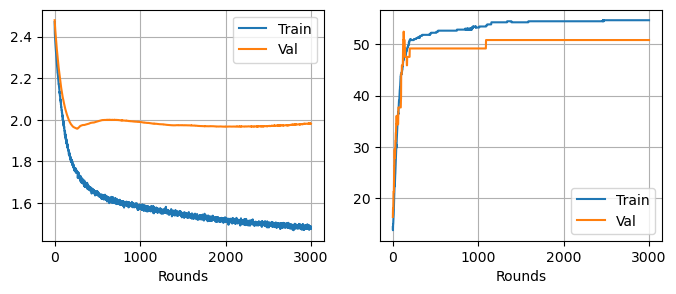

n_layer: 5
[Epoch 0]  Train Loss: 2.5991508960723877  Train Acc: 6.30  Val Loss: 2.48458194732666  Train Acc: 4.92
[Epoch 500]  Train Loss: 1.7153389006853104  Train Acc: 50.81  Val Loss: 1.763047218322754  Train Acc: 44.26
[Epoch 1000]  Train Loss: 1.5670198649168015  Train Acc: 52.85  Val Loss: 1.763780951499939  Train Acc: 47.54
[Epoch 1500]  Train Loss: 1.5263778418302536  Train Acc: 53.05  Val Loss: 1.7602450847625732  Train Acc: 47.54
[Epoch 2000]  Train Loss: 1.4942748695611954  Train Acc: 53.25  Val Loss: 1.760218858718872  Train Acc: 49.18
[Epoch 2500]  Train Loss: 1.467773661017418  Train Acc: 54.07  Val Loss: 1.7553247213363647  Train Acc: 50.82
[Epoch 2999]  Train Loss: 1.4405574649572372  Train Acc: 54.27  Val Loss: 1.7555259466171265  Train Acc: 50.82


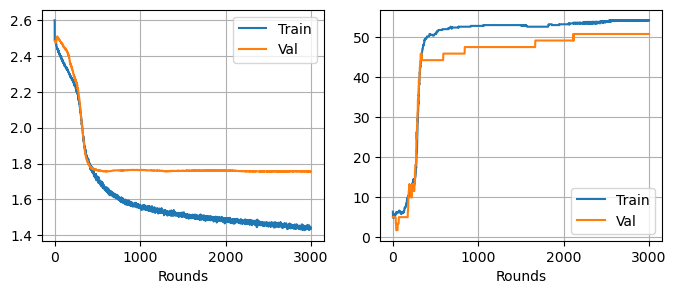

# ===== hid_dim: 150 ===== #
n_layer: 1
[Epoch 0]  Train Loss: 2141.4688873291016  Train Acc: 33.33  Val Loss: 1642.1160888671875  Train Acc: 50.82
[Epoch 500]  Train Loss: 0.7533615417778492  Train Acc: 80.69  Val Loss: 25.11528205871582  Train Acc: 37.70
[Epoch 1000]  Train Loss: 0.1289628972299397  Train Acc: 96.75  Val Loss: 26.43758201599121  Train Acc: 37.70
[Epoch 1500]  Train Loss: 0.09689053567126393  Train Acc: 97.56  Val Loss: 25.997438430786133  Train Acc: 34.43
[Epoch 2000]  Train Loss: 0.0790778761729598  Train Acc: 97.97  Val Loss: 26.964000701904297  Train Acc: 36.07
[Epoch 2500]  Train Loss: 0.05775066278874874  Train Acc: 98.78  Val Loss: 27.77411651611328  Train Acc: 32.79
[Epoch 2999]  Train Loss: 0.048131045419722795  Train Acc: 99.19  Val Loss: 28.134801864624023  Train Acc: 32.79


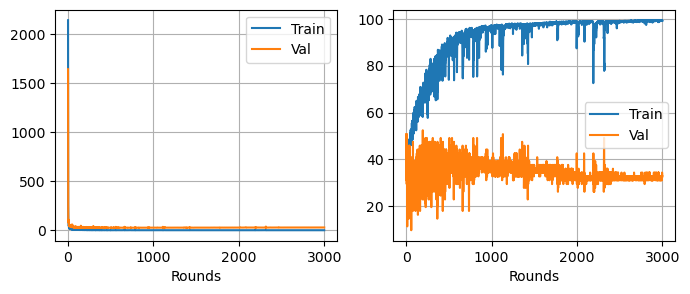

n_layer: 2
[Epoch 0]  Train Loss: 2.398697316646576  Train Acc: 11.59  Val Loss: 2.334411859512329  Train Acc: 22.95
[Epoch 500]  Train Loss: 1.5282534658908844  Train Acc: 53.66  Val Loss: 1.7422020435333252  Train Acc: 49.18
[Epoch 1000]  Train Loss: 1.4585783332586288  Train Acc: 54.27  Val Loss: 1.7160907983779907  Train Acc: 49.18
[Epoch 1500]  Train Loss: 1.4246866405010223  Train Acc: 54.67  Val Loss: 1.7069437503814697  Train Acc: 50.82
[Epoch 2000]  Train Loss: 1.3854252845048904  Train Acc: 55.08  Val Loss: 1.7016743421554565  Train Acc: 52.46
[Epoch 2500]  Train Loss: 1.3693381398916245  Train Acc: 55.49  Val Loss: 1.7030588388442993  Train Acc: 52.46
[Epoch 2999]  Train Loss: 1.3518270552158356  Train Acc: 55.89  Val Loss: 1.711456298828125  Train Acc: 52.46


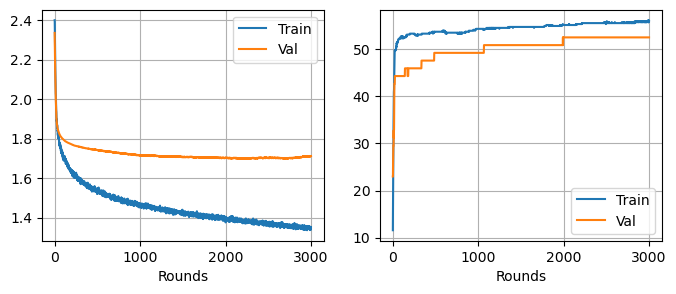

n_layer: 3
[Epoch 0]  Train Loss: 2.451685279607773  Train Acc: 12.60  Val Loss: 2.234839677810669  Train Acc: 22.95
[Epoch 500]  Train Loss: 1.5452056974172592  Train Acc: 53.66  Val Loss: 1.7041690349578857  Train Acc: 45.90
[Epoch 1000]  Train Loss: 1.4512865096330643  Train Acc: 54.67  Val Loss: 1.7069613933563232  Train Acc: 52.46
[Epoch 1500]  Train Loss: 1.4087151139974594  Train Acc: 55.89  Val Loss: 1.719813346862793  Train Acc: 52.46
[Epoch 2000]  Train Loss: 1.3679051101207733  Train Acc: 55.69  Val Loss: 1.7313206195831299  Train Acc: 52.46
[Epoch 2500]  Train Loss: 1.3385334461927414  Train Acc: 55.69  Val Loss: 1.7449015378952026  Train Acc: 52.46
[Epoch 2999]  Train Loss: 1.3150065541267395  Train Acc: 56.10  Val Loss: 1.7583643198013306  Train Acc: 52.46


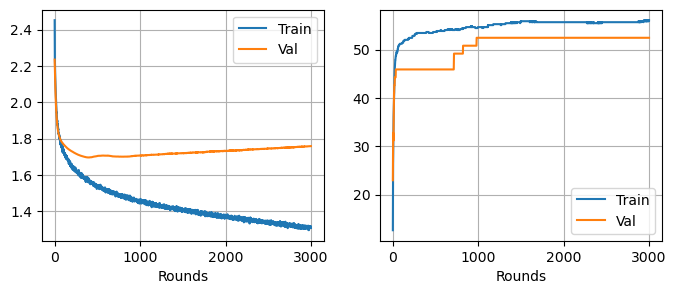

n_layer: 4
[Epoch 0]  Train Loss: 2.4921444058418274  Train Acc: 10.37  Val Loss: 2.4090776443481445  Train Acc: 6.56
[Epoch 500]  Train Loss: 1.5588603615760803  Train Acc: 54.27  Val Loss: 1.7525380849838257  Train Acc: 49.18
[Epoch 1000]  Train Loss: 1.4964047372341156  Train Acc: 53.66  Val Loss: 1.7834811210632324  Train Acc: 49.18
[Epoch 1500]  Train Loss: 1.4512185752391815  Train Acc: 54.07  Val Loss: 1.7945561408996582  Train Acc: 49.18
[Epoch 2000]  Train Loss: 1.4134454280138016  Train Acc: 54.67  Val Loss: 1.8015588521957397  Train Acc: 50.82
[Epoch 2500]  Train Loss: 1.3747262358665466  Train Acc: 55.28  Val Loss: 1.811625361442566  Train Acc: 50.82
[Epoch 2999]  Train Loss: 1.3549182713031769  Train Acc: 55.89  Val Loss: 1.8173185586929321  Train Acc: 52.46


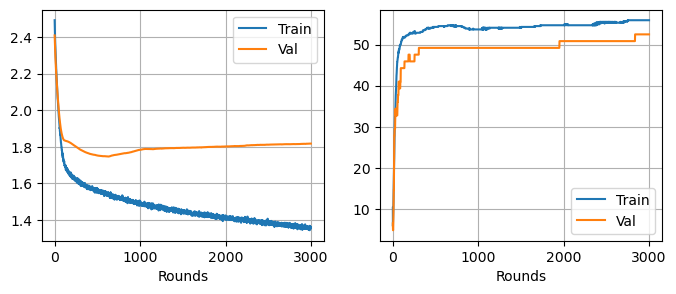

n_layer: 5
[Epoch 0]  Train Loss: 2.51061949133873  Train Acc: 8.13  Val Loss: 2.2725794315338135  Train Acc: 9.84
[Epoch 500]  Train Loss: 1.5669040828943253  Train Acc: 53.25  Val Loss: 1.6742136478424072  Train Acc: 49.18
[Epoch 1000]  Train Loss: 1.477916345000267  Train Acc: 55.49  Val Loss: 1.6623945236206055  Train Acc: 47.54
[Epoch 1500]  Train Loss: 1.412850245833397  Train Acc: 56.30  Val Loss: 1.661368489265442  Train Acc: 50.82
[Epoch 2000]  Train Loss: 1.3668794333934784  Train Acc: 56.30  Val Loss: 1.6735304594039917  Train Acc: 50.82
[Epoch 2500]  Train Loss: 1.329628899693489  Train Acc: 57.52  Val Loss: 1.6899454593658447  Train Acc: 49.18
[Epoch 2999]  Train Loss: 1.2918467074632645  Train Acc: 57.93  Val Loss: 1.7341138124465942  Train Acc: 49.18


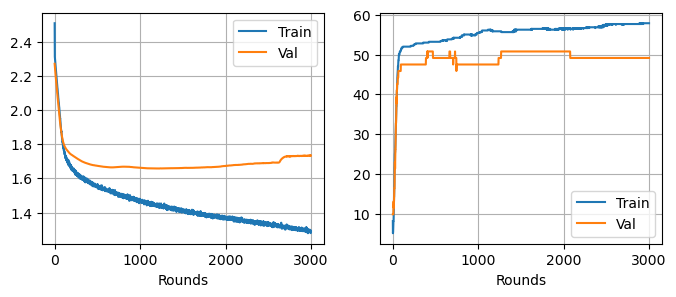

# ===== hid_dim: 450 ===== #
n_layer: 1
[Epoch 0]  Train Loss: 6235.198013305664  Train Acc: 30.28  Val Loss: 2778.233642578125  Train Acc: 50.82
[Epoch 500]  Train Loss: 0.39684861339628696  Train Acc: 94.92  Val Loss: 42.265995025634766  Train Acc: 37.70
[Epoch 1000]  Train Loss: 0.03067871369421482  Train Acc: 99.39  Val Loss: 44.67392349243164  Train Acc: 37.70
[Epoch 1500]  Train Loss: 0.028246679896255955  Train Acc: 98.98  Val Loss: 43.8360710144043  Train Acc: 37.70
[Epoch 2000]  Train Loss: 0.026896127761574462  Train Acc: 99.39  Val Loss: 44.66989517211914  Train Acc: 37.70
[Epoch 2500]  Train Loss: 0.014822950877714902  Train Acc: 99.59  Val Loss: 45.02492904663086  Train Acc: 34.43
[Epoch 2999]  Train Loss: 0.009051896835444495  Train Acc: 99.80  Val Loss: 45.252845764160156  Train Acc: 34.43


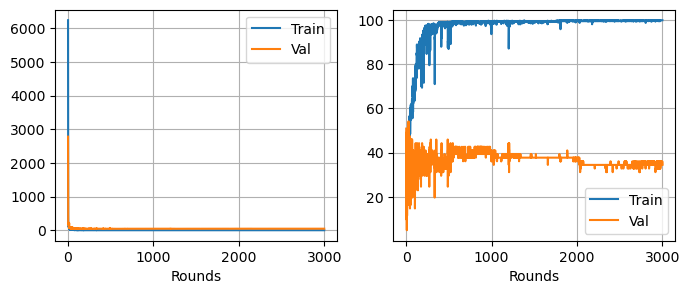

n_layer: 2
[Epoch 0]  Train Loss: 2.3955350518226624  Train Acc: 9.96  Val Loss: 2.541090726852417  Train Acc: 6.56
[Epoch 500]  Train Loss: 1.3695461004972458  Train Acc: 56.10  Val Loss: 1.8305350542068481  Train Acc: 47.54
[Epoch 1000]  Train Loss: 1.2872132658958435  Train Acc: 57.72  Val Loss: 1.9786076545715332  Train Acc: 47.54
[Epoch 1500]  Train Loss: 1.2332591265439987  Train Acc: 59.55  Val Loss: 2.0744993686676025  Train Acc: 47.54
[Epoch 2000]  Train Loss: 1.168415829539299  Train Acc: 60.77  Val Loss: 2.1771817207336426  Train Acc: 47.54
[Epoch 2500]  Train Loss: 1.1278260126709938  Train Acc: 62.40  Val Loss: 2.2934885025024414  Train Acc: 45.90
[Epoch 2999]  Train Loss: 1.1014421880245209  Train Acc: 63.82  Val Loss: 2.358565330505371  Train Acc: 45.90


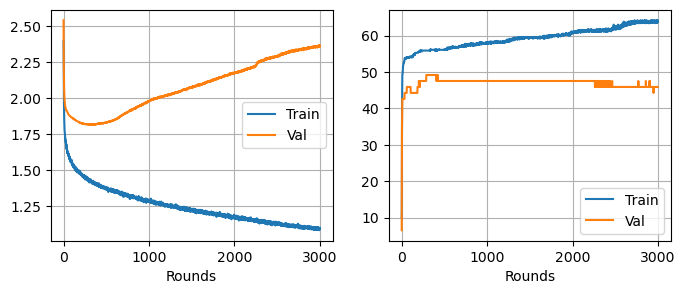

n_layer: 3
[Epoch 0]  Train Loss: 2.5395628809928894  Train Acc: 6.91  Val Loss: 2.361410617828369  Train Acc: 9.84
[Epoch 500]  Train Loss: 1.3671310991048813  Train Acc: 55.89  Val Loss: 1.716607689857483  Train Acc: 49.18
[Epoch 1000]  Train Loss: 1.2842066586017609  Train Acc: 57.72  Val Loss: 1.7264028787612915  Train Acc: 49.18
[Epoch 1500]  Train Loss: 1.2112144976854324  Train Acc: 59.15  Val Loss: 1.7646682262420654  Train Acc: 49.18
[Epoch 2000]  Train Loss: 1.1585407108068466  Train Acc: 60.16  Val Loss: 1.8160276412963867  Train Acc: 47.54
[Epoch 2500]  Train Loss: 1.1022516936063766  Train Acc: 61.18  Val Loss: 1.8772954940795898  Train Acc: 47.54
[Epoch 2999]  Train Loss: 1.0580130442976952  Train Acc: 63.21  Val Loss: 1.9425970315933228  Train Acc: 47.54


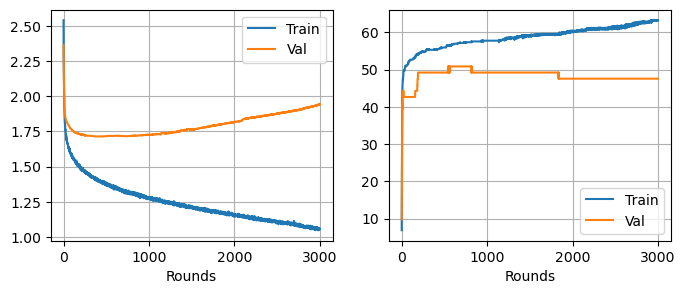

n_layer: 4
[Epoch 0]  Train Loss: 2.521711081266403  Train Acc: 9.96  Val Loss: 2.469576120376587  Train Acc: 8.20
[Epoch 500]  Train Loss: 1.3489629924297333  Train Acc: 57.11  Val Loss: 1.7357075214385986  Train Acc: 52.46
[Epoch 1000]  Train Loss: 1.2251087427139282  Train Acc: 59.96  Val Loss: 1.7806206941604614  Train Acc: 52.46
[Epoch 1500]  Train Loss: 1.1422643959522247  Train Acc: 61.18  Val Loss: 1.8733683824539185  Train Acc: 50.82
[Epoch 2000]  Train Loss: 1.0714353621006012  Train Acc: 63.01  Val Loss: 1.9318243265151978  Train Acc: 50.82
[Epoch 2500]  Train Loss: 1.0042228698730469  Train Acc: 66.06  Val Loss: 2.031179904937744  Train Acc: 49.18
[Epoch 2999]  Train Loss: 0.9421736970543861  Train Acc: 68.70  Val Loss: 2.1139087677001953  Train Acc: 47.54


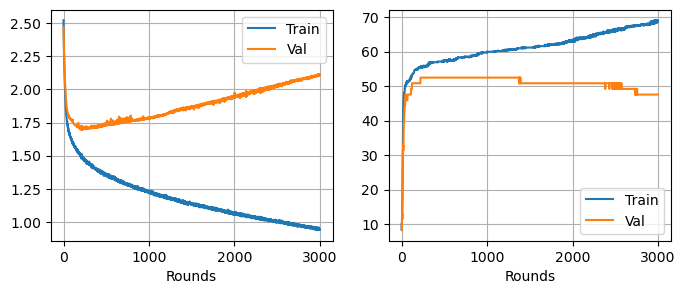

n_layer: 5
[Epoch 0]  Train Loss: 2.478847861289978  Train Acc: 10.16  Val Loss: 2.5012316703796387  Train Acc: 0.00
[Epoch 500]  Train Loss: 1.3759715408086777  Train Acc: 55.69  Val Loss: 1.714708924293518  Train Acc: 45.90
[Epoch 1000]  Train Loss: 1.2671423554420471  Train Acc: 58.33  Val Loss: 1.6693516969680786  Train Acc: 47.54
[Epoch 1500]  Train Loss: 1.189048781991005  Train Acc: 60.57  Val Loss: 1.6753746271133423  Train Acc: 49.18
[Epoch 2000]  Train Loss: 1.1043528765439987  Train Acc: 63.01  Val Loss: 1.7062472105026245  Train Acc: 49.18
[Epoch 2500]  Train Loss: 1.0583981573581696  Train Acc: 65.24  Val Loss: 1.7398898601531982  Train Acc: 50.82
[Epoch 2999]  Train Loss: 0.9887973368167877  Train Acc: 67.07  Val Loss: 1.7809345722198486  Train Acc: 50.82


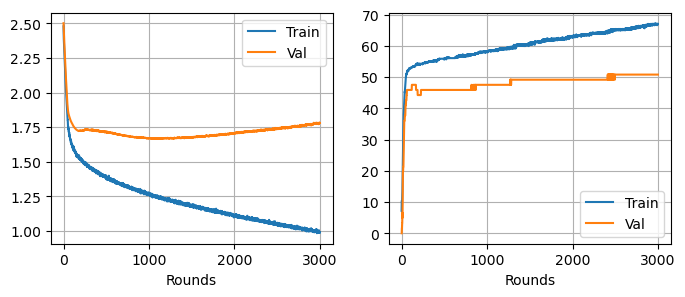

best set of exp2:  [52.45901639344264, 1.7039820024967194, 150, 2]


In [ ]:
seed = 1228
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = 'exp2'

# ====== Model Capacity ====== #
args.in_dim = exp0_best_set[2]
args.out_dim = out_dim
args.hid_dim = 0        #########################
args.act = 'relu'
args.n_layer = 0        #########################

# ====== Regularization ======= #
args.dropout = 0.2
args.use_bn = True
args.l2 = 0.000001
args.use_xavier = True

# ====== Optimizer & Training ====== #
args.optim = exp1_best_set[2]
args.lr = exp1_best_set[3]

# ====== Federated Learning Parameters ====== #
args.epochs = 3000
args.train_batch_size = 64
args.test_batch_size = 64

args.feat = exp0_best_set[2]
#================================================================================#
name_var1 = 'hid_dim'
name_var2 = 'n_layer'
list_var1 = [5, 15, 50, 150, 450, 1000]
list_var2 = [1, 2, 3, 4, 5]

exp2_best_set = [0, 100000, 0, 0]

for var1 in list_var1:
    print(f'# ===== {name_var1}: {var1} ===== #')
    setattr(args, name_var1, var1)
    for var2 in list_var2:
        setattr(args, name_var2, var2)
        print(f'{name_var2}: {var2}')

        partition = make_dataset(feature_idx, sleep_data, survey_data, args)

        train_losses, val_losses, train_acces, val_acces = experiment(partition, args)
        plot_loss(train_losses, val_losses, train_acces, val_acces)

        mean_loss, mean_acc = np.mean(val_losses[-500:]), np.mean(val_acces[-500:])

        if mean_acc > exp2_best_set[0] and (mean_loss < exp2_best_set[1]):
            exp2_best_set[0], exp2_best_set[1], exp2_best_set[2], exp2_best_set[3] = mean_acc, mean_loss, var1, var2

print('best set of exp2: ', exp2_best_set)

#### **Ex3) *dropout vs l2***

# ===== dropout: 0.05 ===== #
l2: 1e-06
[Epoch 0]  Train Loss: 2.4156872034072876  Train Acc: 7.32  Val Loss: 2.845336437225342  Train Acc: 4.92
[Epoch 500]  Train Loss: 1.5042843669652939  Train Acc: 55.69  Val Loss: 1.8916887044906616  Train Acc: 45.90
[Epoch 1000]  Train Loss: 1.4201718270778656  Train Acc: 55.08  Val Loss: 1.882932186126709  Train Acc: 47.54
[Epoch 1500]  Train Loss: 1.378626823425293  Train Acc: 55.89  Val Loss: 1.8669838905334473  Train Acc: 47.54
[Epoch 2000]  Train Loss: 1.3472374230623245  Train Acc: 55.89  Val Loss: 1.8483805656433105  Train Acc: 49.18
[Epoch 2500]  Train Loss: 1.3149909675121307  Train Acc: 56.10  Val Loss: 1.8393430709838867  Train Acc: 49.18
[Epoch 2999]  Train Loss: 1.2992517054080963  Train Acc: 56.91  Val Loss: 1.8372284173965454  Train Acc: 49.18


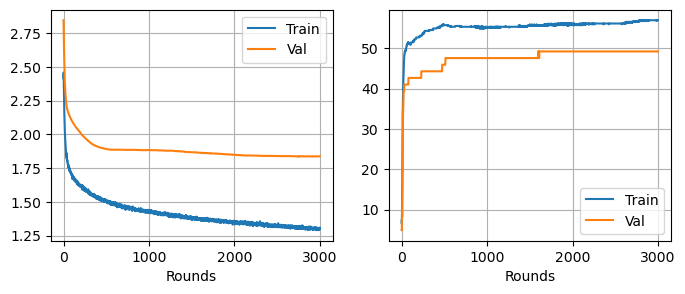

l2: 1e-05
[Epoch 0]  Train Loss: 2.37513530254364  Train Acc: 10.16  Val Loss: 2.1618762016296387  Train Acc: 18.03
[Epoch 500]  Train Loss: 1.557684525847435  Train Acc: 53.66  Val Loss: 1.7935327291488647  Train Acc: 47.54
[Epoch 1000]  Train Loss: 1.4642042517662048  Train Acc: 54.88  Val Loss: 1.7758440971374512  Train Acc: 49.18
[Epoch 1500]  Train Loss: 1.43528650701046  Train Acc: 55.08  Val Loss: 1.7834733724594116  Train Acc: 49.18
[Epoch 2000]  Train Loss: 1.4120272397994995  Train Acc: 55.69  Val Loss: 1.7946679592132568  Train Acc: 49.18
[Epoch 2500]  Train Loss: 1.380685955286026  Train Acc: 56.10  Val Loss: 1.799272060394287  Train Acc: 49.18
[Epoch 2999]  Train Loss: 1.3706015199422836  Train Acc: 56.50  Val Loss: 1.8110531568527222  Train Acc: 50.82


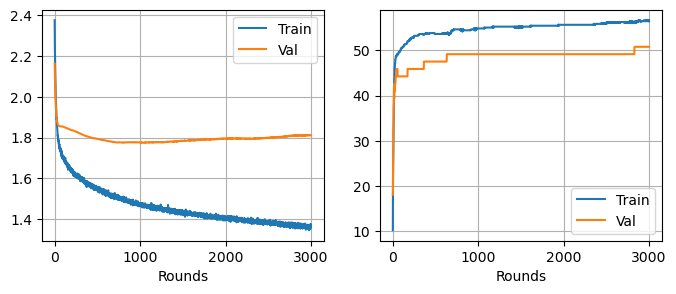

l2: 0.0001
[Epoch 0]  Train Loss: 2.390153259038925  Train Acc: 9.76  Val Loss: 2.320974349975586  Train Acc: 8.20
[Epoch 500]  Train Loss: 1.4879585951566696  Train Acc: 53.05  Val Loss: 1.918110728263855  Train Acc: 44.26
[Epoch 1000]  Train Loss: 1.4182700961828232  Train Acc: 55.08  Val Loss: 1.9188950061798096  Train Acc: 45.90
[Epoch 1500]  Train Loss: 1.3721610009670258  Train Acc: 56.30  Val Loss: 1.917988657951355  Train Acc: 47.54
[Epoch 2000]  Train Loss: 1.3323475122451782  Train Acc: 57.11  Val Loss: 1.9450709819793701  Train Acc: 50.82
[Epoch 2500]  Train Loss: 1.2983659952878952  Train Acc: 57.72  Val Loss: 1.9762911796569824  Train Acc: 49.18
[Epoch 2999]  Train Loss: 1.2735693454742432  Train Acc: 58.94  Val Loss: 2.0108554363250732  Train Acc: 49.18


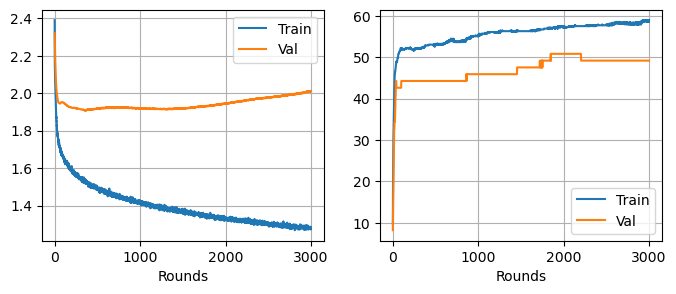

l2: 0.001
[Epoch 0]  Train Loss: 2.4244659543037415  Train Acc: 10.37  Val Loss: 2.809880256652832  Train Acc: 11.48
[Epoch 500]  Train Loss: 1.541179895401001  Train Acc: 56.30  Val Loss: 1.978677749633789  Train Acc: 47.54
[Epoch 1000]  Train Loss: 1.4381821602582932  Train Acc: 56.30  Val Loss: 1.9753342866897583  Train Acc: 47.54
[Epoch 1500]  Train Loss: 1.3948440998792648  Train Acc: 56.50  Val Loss: 1.9867422580718994  Train Acc: 47.54
[Epoch 2000]  Train Loss: 1.3692873269319534  Train Acc: 56.50  Val Loss: 2.0076987743377686  Train Acc: 45.90
[Epoch 2500]  Train Loss: 1.3294298499822617  Train Acc: 57.11  Val Loss: 2.056293249130249  Train Acc: 45.90
[Epoch 2999]  Train Loss: 1.3116507530212402  Train Acc: 57.93  Val Loss: 2.078583240509033  Train Acc: 47.54


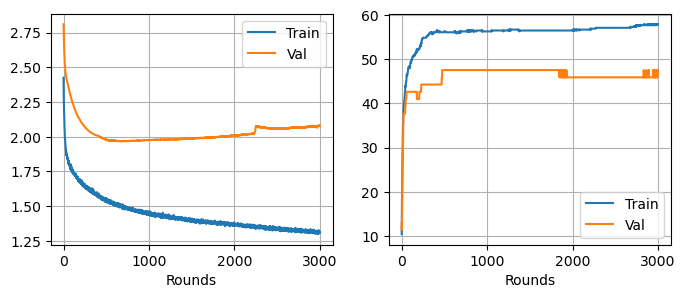

l2: 0.01
[Epoch 0]  Train Loss: 2.4495654702186584  Train Acc: 6.50  Val Loss: 2.610888957977295  Train Acc: 4.92
[Epoch 500]  Train Loss: 1.5252880156040192  Train Acc: 54.47  Val Loss: 1.9891856908798218  Train Acc: 47.54
[Epoch 1000]  Train Loss: 1.4460660964250565  Train Acc: 54.47  Val Loss: 2.1291232109069824  Train Acc: 47.54
[Epoch 1500]  Train Loss: 1.40901680290699  Train Acc: 54.88  Val Loss: 2.2200655937194824  Train Acc: 47.54
[Epoch 2000]  Train Loss: 1.3879402130842209  Train Acc: 55.08  Val Loss: 2.250265121459961  Train Acc: 47.54
[Epoch 2500]  Train Loss: 1.3495336771011353  Train Acc: 54.88  Val Loss: 2.2544150352478027  Train Acc: 45.90
[Epoch 2999]  Train Loss: 1.3368217796087265  Train Acc: 55.69  Val Loss: 2.2576894760131836  Train Acc: 45.90


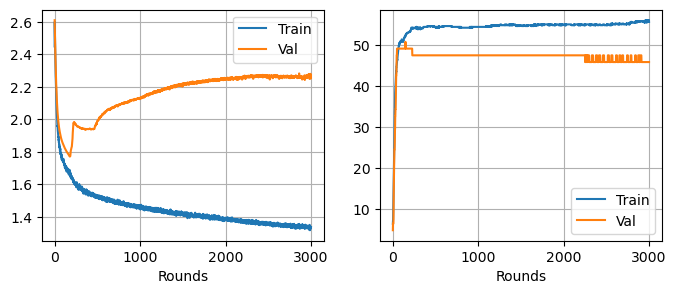

# ===== dropout: 0.1 ===== #
l2: 1e-06
[Epoch 0]  Train Loss: 2.419012635946274  Train Acc: 7.32  Val Loss: 2.402071952819824  Train Acc: 13.11
[Epoch 500]  Train Loss: 1.5417542457580566  Train Acc: 54.47  Val Loss: 1.8520839214324951  Train Acc: 47.54
[Epoch 1000]  Train Loss: 1.4667628109455109  Train Acc: 53.86  Val Loss: 1.8511229753494263  Train Acc: 50.82
[Epoch 1500]  Train Loss: 1.4131985753774643  Train Acc: 54.88  Val Loss: 1.833406686782837  Train Acc: 50.82
[Epoch 2000]  Train Loss: 1.3783788532018661  Train Acc: 55.69  Val Loss: 1.8220784664154053  Train Acc: 50.82
[Epoch 2500]  Train Loss: 1.356108546257019  Train Acc: 55.89  Val Loss: 1.8275929689407349  Train Acc: 49.18
[Epoch 2999]  Train Loss: 1.351269707083702  Train Acc: 56.10  Val Loss: 1.8122447729110718  Train Acc: 49.18


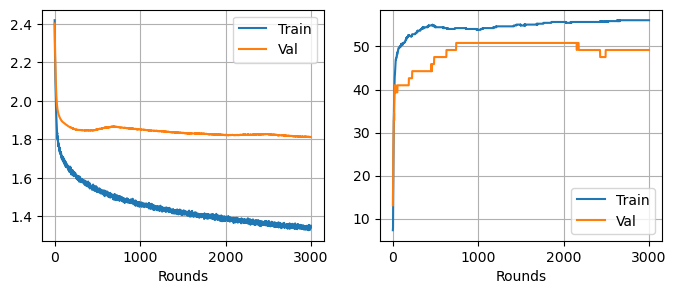

l2: 1e-05
[Epoch 0]  Train Loss: 2.472842365503311  Train Acc: 7.72  Val Loss: 2.682082176208496  Train Acc: 13.11
[Epoch 500]  Train Loss: 1.5622702538967133  Train Acc: 54.07  Val Loss: 1.80656099319458  Train Acc: 50.82
[Epoch 1000]  Train Loss: 1.4856849610805511  Train Acc: 55.28  Val Loss: 1.7812621593475342  Train Acc: 50.82
[Epoch 1500]  Train Loss: 1.4505999088287354  Train Acc: 55.49  Val Loss: 1.7918672561645508  Train Acc: 50.82
[Epoch 2000]  Train Loss: 1.4168878197669983  Train Acc: 55.49  Val Loss: 1.8055998086929321  Train Acc: 50.82
[Epoch 2500]  Train Loss: 1.3996617197990417  Train Acc: 55.28  Val Loss: 1.8151129484176636  Train Acc: 50.82
[Epoch 2999]  Train Loss: 1.3607285022735596  Train Acc: 55.28  Val Loss: 1.8331137895584106  Train Acc: 50.82


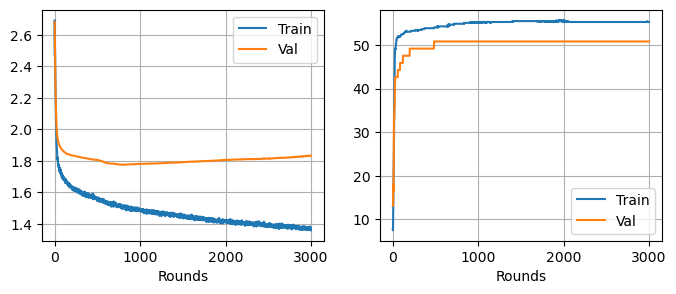

l2: 0.0001
[Epoch 0]  Train Loss: 2.4290024638175964  Train Acc: 8.54  Val Loss: 2.291996955871582  Train Acc: 13.11
[Epoch 500]  Train Loss: 1.5050098150968552  Train Acc: 53.66  Val Loss: 1.7265920639038086  Train Acc: 47.54
[Epoch 1000]  Train Loss: 1.4364136010408401  Train Acc: 54.67  Val Loss: 1.7289420366287231  Train Acc: 49.18
[Epoch 1500]  Train Loss: 1.38260218501091  Train Acc: 54.88  Val Loss: 1.7407610416412354  Train Acc: 50.82
[Epoch 2000]  Train Loss: 1.3581535369157791  Train Acc: 55.28  Val Loss: 1.7539476156234741  Train Acc: 49.18
[Epoch 2500]  Train Loss: 1.3265843838453293  Train Acc: 55.28  Val Loss: 1.7708539962768555  Train Acc: 49.18
[Epoch 2999]  Train Loss: 1.3085306584835052  Train Acc: 56.91  Val Loss: 1.787453532218933  Train Acc: 49.18


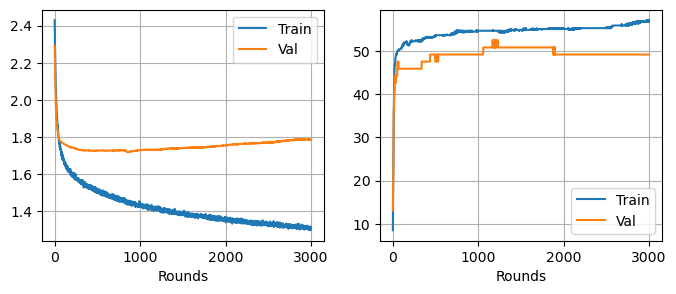

l2: 0.001
[Epoch 0]  Train Loss: 2.377974420785904  Train Acc: 8.94  Val Loss: 2.669781446456909  Train Acc: 1.64
[Epoch 500]  Train Loss: 1.4581727981567383  Train Acc: 55.08  Val Loss: 1.739302635192871  Train Acc: 50.82
[Epoch 1000]  Train Loss: 1.406743660569191  Train Acc: 55.89  Val Loss: 1.7544444799423218  Train Acc: 50.82
[Epoch 1500]  Train Loss: 1.3608624637126923  Train Acc: 56.30  Val Loss: 1.8047871589660645  Train Acc: 50.82
[Epoch 2000]  Train Loss: 1.3425368517637253  Train Acc: 56.91  Val Loss: 1.8597997426986694  Train Acc: 50.82
[Epoch 2500]  Train Loss: 1.3063901215791702  Train Acc: 57.32  Val Loss: 1.9108970165252686  Train Acc: 50.82
[Epoch 2999]  Train Loss: 1.28968146443367  Train Acc: 56.91  Val Loss: 1.947226881980896  Train Acc: 50.82


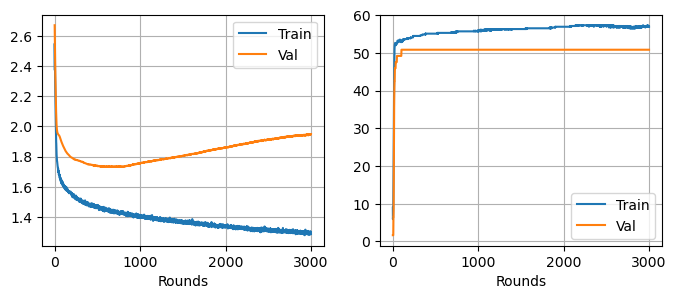

l2: 0.01
[Epoch 0]  Train Loss: 2.3918671905994415  Train Acc: 12.20  Val Loss: 2.6795284748077393  Train Acc: 8.20
[Epoch 500]  Train Loss: 1.493202194571495  Train Acc: 54.67  Val Loss: 1.6357717514038086  Train Acc: 50.82
[Epoch 1000]  Train Loss: 1.4442075043916702  Train Acc: 55.49  Val Loss: 1.6186246871948242  Train Acc: 50.82
[Epoch 1500]  Train Loss: 1.413180097937584  Train Acc: 55.49  Val Loss: 1.6124341487884521  Train Acc: 50.82
[Epoch 2000]  Train Loss: 1.3883518129587173  Train Acc: 55.89  Val Loss: 1.6139163970947266  Train Acc: 50.82
[Epoch 2500]  Train Loss: 1.3627047389745712  Train Acc: 56.10  Val Loss: 1.615738034248352  Train Acc: 50.82
[Epoch 2999]  Train Loss: 1.3458027243614197  Train Acc: 56.50  Val Loss: 1.614925503730774  Train Acc: 50.82


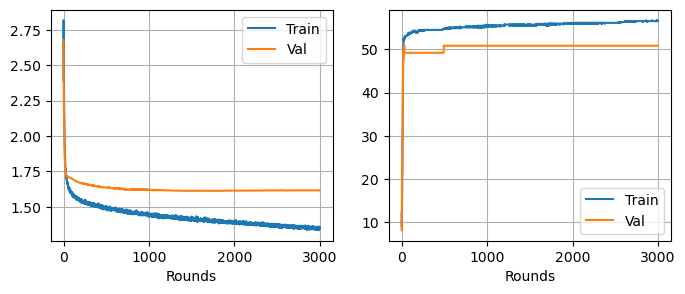

# ===== dropout: 0.15 ===== #
l2: 1e-06
[Epoch 0]  Train Loss: 2.42069011926651  Train Acc: 9.76  Val Loss: 2.453606605529785  Train Acc: 8.20
[Epoch 500]  Train Loss: 1.5080522894859314  Train Acc: 54.27  Val Loss: 1.7851861715316772  Train Acc: 44.26
[Epoch 1000]  Train Loss: 1.426211640238762  Train Acc: 55.28  Val Loss: 1.9451987743377686  Train Acc: 42.62
[Epoch 1500]  Train Loss: 1.3778398633003235  Train Acc: 55.49  Val Loss: 1.98805832862854  Train Acc: 47.54
[Epoch 2000]  Train Loss: 1.3422887474298477  Train Acc: 55.89  Val Loss: 2.0075435638427734  Train Acc: 47.54
[Epoch 2500]  Train Loss: 1.3250422924757004  Train Acc: 57.11  Val Loss: 2.0451812744140625  Train Acc: 47.54
[Epoch 2999]  Train Loss: 1.295596644282341  Train Acc: 57.52  Val Loss: 2.0799307823181152  Train Acc: 47.54


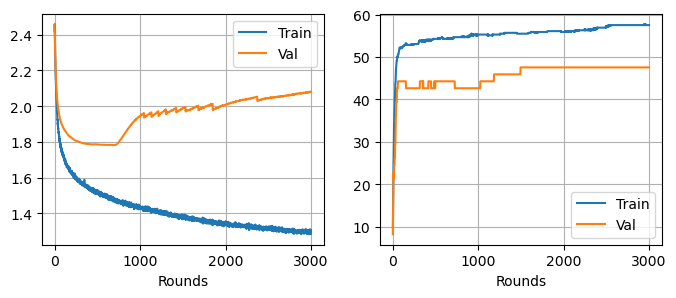

l2: 1e-05
[Epoch 0]  Train Loss: 2.452281177043915  Train Acc: 8.13  Val Loss: 2.221999406814575  Train Acc: 13.11
[Epoch 500]  Train Loss: 1.5043019652366638  Train Acc: 53.86  Val Loss: 1.6877939701080322  Train Acc: 50.82
[Epoch 1000]  Train Loss: 1.4184197634458542  Train Acc: 55.49  Val Loss: 1.6852585077285767  Train Acc: 52.46
[Epoch 1500]  Train Loss: 1.353115975856781  Train Acc: 56.91  Val Loss: 1.7037359476089478  Train Acc: 52.46
[Epoch 2000]  Train Loss: 1.3333088755607605  Train Acc: 57.93  Val Loss: 1.7264447212219238  Train Acc: 50.82
[Epoch 2500]  Train Loss: 1.2940945029258728  Train Acc: 58.13  Val Loss: 1.741877794265747  Train Acc: 49.18
[Epoch 2999]  Train Loss: 1.2713745385408401  Train Acc: 58.13  Val Loss: 1.7535731792449951  Train Acc: 49.18


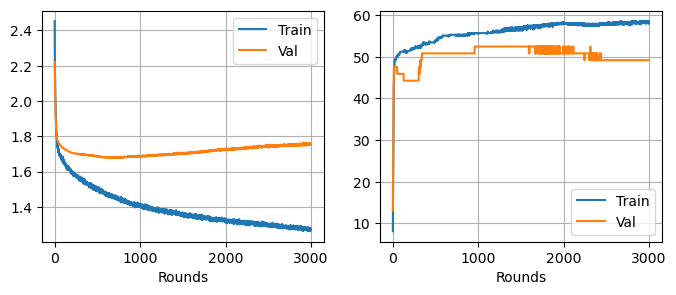

l2: 0.0001
[Epoch 0]  Train Loss: 2.372682571411133  Train Acc: 11.99  Val Loss: 2.5881309509277344  Train Acc: 11.48
[Epoch 500]  Train Loss: 1.5136710703372955  Train Acc: 54.88  Val Loss: 1.766709327697754  Train Acc: 50.82
[Epoch 1000]  Train Loss: 1.4397851824760437  Train Acc: 55.89  Val Loss: 1.7830756902694702  Train Acc: 52.46
[Epoch 1500]  Train Loss: 1.3971268385648727  Train Acc: 56.50  Val Loss: 1.7797917127609253  Train Acc: 52.46
[Epoch 2000]  Train Loss: 1.3656225949525833  Train Acc: 57.52  Val Loss: 1.7985256910324097  Train Acc: 50.82
[Epoch 2500]  Train Loss: 1.3543587774038315  Train Acc: 58.13  Val Loss: 1.8241465091705322  Train Acc: 49.18
[Epoch 2999]  Train Loss: 1.3256493955850601  Train Acc: 58.54  Val Loss: 1.8468046188354492  Train Acc: 49.18


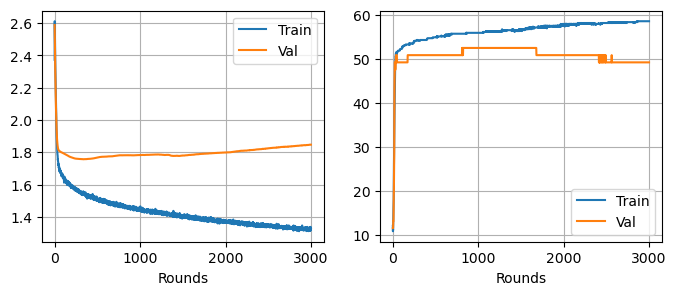

l2: 0.001
[Epoch 0]  Train Loss: 2.400066077709198  Train Acc: 14.23  Val Loss: 2.506781816482544  Train Acc: 16.39
[Epoch 500]  Train Loss: 1.5206135213375092  Train Acc: 54.88  Val Loss: 1.7493224143981934  Train Acc: 47.54
[Epoch 1000]  Train Loss: 1.442213848233223  Train Acc: 55.69  Val Loss: 1.7432559728622437  Train Acc: 50.82
[Epoch 1500]  Train Loss: 1.3807896077632904  Train Acc: 55.89  Val Loss: 1.7584360837936401  Train Acc: 50.82
[Epoch 2000]  Train Loss: 1.3598436415195465  Train Acc: 56.30  Val Loss: 1.7797831296920776  Train Acc: 50.82
[Epoch 2500]  Train Loss: 1.3370296657085419  Train Acc: 56.91  Val Loss: 1.8038924932479858  Train Acc: 50.82
[Epoch 2999]  Train Loss: 1.302885040640831  Train Acc: 58.13  Val Loss: 1.827122449874878  Train Acc: 50.82


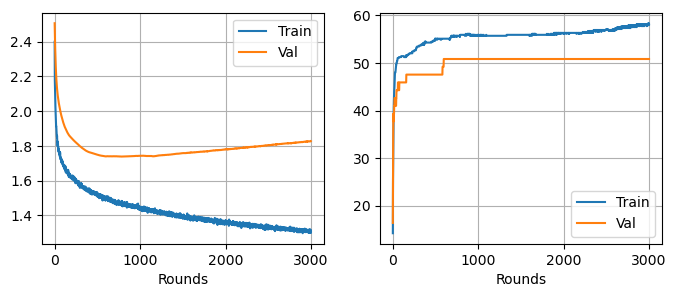

l2: 0.01
[Epoch 0]  Train Loss: 2.4949916899204254  Train Acc: 10.98  Val Loss: 2.1313188076019287  Train Acc: 40.98
[Epoch 500]  Train Loss: 1.5297453701496124  Train Acc: 54.88  Val Loss: 2.0789737701416016  Train Acc: 42.62
[Epoch 1000]  Train Loss: 1.446735993027687  Train Acc: 56.50  Val Loss: 2.123734474182129  Train Acc: 47.54
[Epoch 1500]  Train Loss: 1.3863416612148285  Train Acc: 56.71  Val Loss: 2.1689517498016357  Train Acc: 47.54
[Epoch 2000]  Train Loss: 1.3441034108400345  Train Acc: 56.50  Val Loss: 2.188290596008301  Train Acc: 45.90
[Epoch 2500]  Train Loss: 1.3133016228675842  Train Acc: 57.32  Val Loss: 2.192223072052002  Train Acc: 45.90
[Epoch 2999]  Train Loss: 1.2818987220525742  Train Acc: 58.13  Val Loss: 2.2025558948516846  Train Acc: 45.90


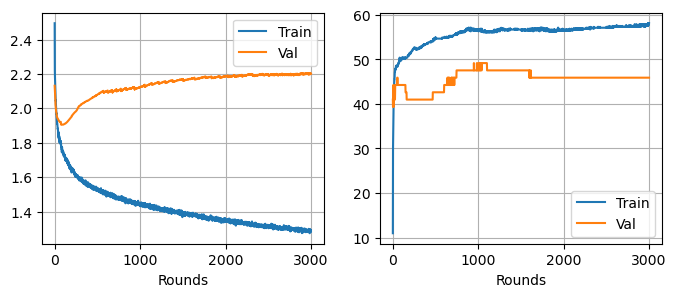

# ===== dropout: 0.2 ===== #
l2: 1e-06
[Epoch 0]  Train Loss: 2.4329457581043243  Train Acc: 15.65  Val Loss: 2.5285818576812744  Train Acc: 14.75
[Epoch 500]  Train Loss: 1.5049403607845306  Train Acc: 54.27  Val Loss: 1.7295680046081543  Train Acc: 50.82
[Epoch 1000]  Train Loss: 1.4463444501161575  Train Acc: 54.88  Val Loss: 1.7269612550735474  Train Acc: 50.82
[Epoch 1500]  Train Loss: 1.4132458567619324  Train Acc: 55.49  Val Loss: 1.7231818437576294  Train Acc: 50.82
[Epoch 2000]  Train Loss: 1.3697978556156158  Train Acc: 56.91  Val Loss: 1.738105058670044  Train Acc: 50.82
[Epoch 2500]  Train Loss: 1.3562142550945282  Train Acc: 56.91  Val Loss: 1.7599142789840698  Train Acc: 50.82
[Epoch 2999]  Train Loss: 1.337966963648796  Train Acc: 57.11  Val Loss: 1.7782564163208008  Train Acc: 50.82


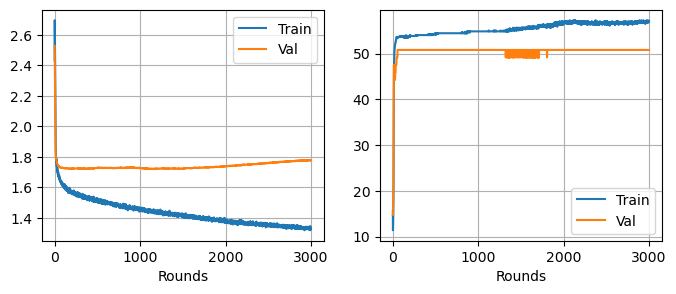

l2: 1e-05
[Epoch 0]  Train Loss: 2.4485849142074585  Train Acc: 13.82  Val Loss: 3.0994529724121094  Train Acc: 6.56
[Epoch 500]  Train Loss: 1.5039486289024353  Train Acc: 54.67  Val Loss: 2.095655918121338  Train Acc: 47.54
[Epoch 1000]  Train Loss: 1.4402615875005722  Train Acc: 54.88  Val Loss: 2.109302520751953  Train Acc: 49.18
[Epoch 1500]  Train Loss: 1.3973220437765121  Train Acc: 54.88  Val Loss: 2.1089131832122803  Train Acc: 49.18
[Epoch 2000]  Train Loss: 1.3703107684850693  Train Acc: 55.28  Val Loss: 2.1141254901885986  Train Acc: 50.82
[Epoch 2500]  Train Loss: 1.356042429804802  Train Acc: 55.49  Val Loss: 2.1245272159576416  Train Acc: 50.82
[Epoch 2999]  Train Loss: 1.3370401561260223  Train Acc: 55.89  Val Loss: 2.1505472660064697  Train Acc: 50.82


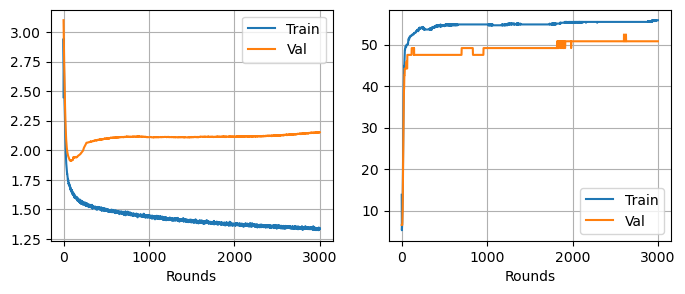

l2: 0.0001
[Epoch 0]  Train Loss: 2.4585573077201843  Train Acc: 3.05  Val Loss: 2.970947742462158  Train Acc: 1.64
[Epoch 500]  Train Loss: 1.4937372207641602  Train Acc: 54.07  Val Loss: 2.3054721355438232  Train Acc: 47.54
[Epoch 1000]  Train Loss: 1.4330442249774933  Train Acc: 55.49  Val Loss: 2.4132838249206543  Train Acc: 47.54
[Epoch 1500]  Train Loss: 1.3872544914484024  Train Acc: 55.69  Val Loss: 2.481031656265259  Train Acc: 49.18
[Epoch 2000]  Train Loss: 1.3542456924915314  Train Acc: 55.69  Val Loss: 2.532588005065918  Train Acc: 49.18
[Epoch 2500]  Train Loss: 1.3402892649173737  Train Acc: 56.10  Val Loss: 2.575105667114258  Train Acc: 49.18
[Epoch 2999]  Train Loss: 1.3074974119663239  Train Acc: 56.10  Val Loss: 2.622154951095581  Train Acc: 49.18


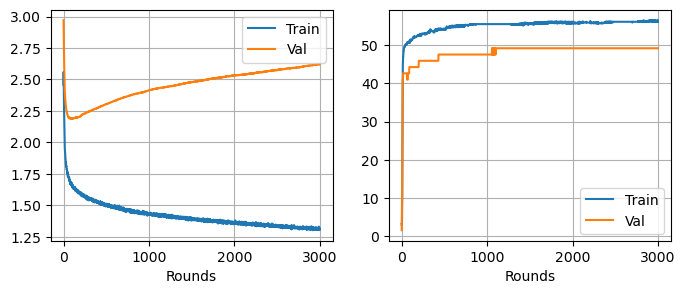

l2: 0.001
[Epoch 0]  Train Loss: 2.3789877593517303  Train Acc: 12.60  Val Loss: 2.606212854385376  Train Acc: 6.56
[Epoch 500]  Train Loss: 1.5413400828838348  Train Acc: 53.25  Val Loss: 1.802756905555725  Train Acc: 47.54
[Epoch 1000]  Train Loss: 1.4450357407331467  Train Acc: 54.07  Val Loss: 1.795413613319397  Train Acc: 50.82
[Epoch 1500]  Train Loss: 1.3995601534843445  Train Acc: 54.88  Val Loss: 1.8084087371826172  Train Acc: 52.46
[Epoch 2000]  Train Loss: 1.358776032924652  Train Acc: 55.08  Val Loss: 1.832301378250122  Train Acc: 50.82
[Epoch 2500]  Train Loss: 1.3336046189069748  Train Acc: 55.28  Val Loss: 1.8575236797332764  Train Acc: 50.82
[Epoch 2999]  Train Loss: 1.3080545663833618  Train Acc: 55.49  Val Loss: 1.893798589706421  Train Acc: 50.82


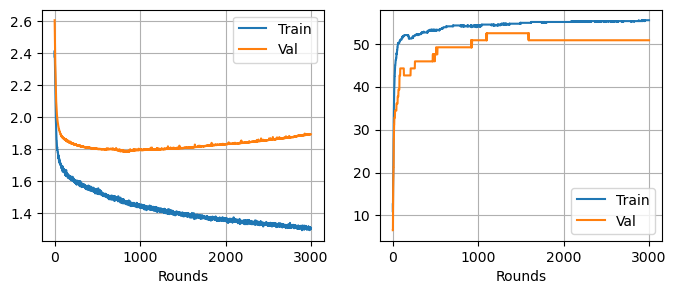

l2: 0.01
[Epoch 0]  Train Loss: 2.4649468660354614  Train Acc: 14.43  Val Loss: 2.644848346710205  Train Acc: 13.11
[Epoch 500]  Train Loss: 1.5499531924724579  Train Acc: 53.05  Val Loss: 1.8333297967910767  Train Acc: 45.90
[Epoch 1000]  Train Loss: 1.452138364315033  Train Acc: 54.88  Val Loss: 1.7995141744613647  Train Acc: 44.26
[Epoch 1500]  Train Loss: 1.4011364877223969  Train Acc: 55.28  Val Loss: 1.8171772956848145  Train Acc: 44.26
[Epoch 2000]  Train Loss: 1.3742478638887405  Train Acc: 56.10  Val Loss: 1.8281924724578857  Train Acc: 44.26
[Epoch 2500]  Train Loss: 1.3506604582071304  Train Acc: 56.50  Val Loss: 1.8409398794174194  Train Acc: 42.62
[Epoch 2999]  Train Loss: 1.331274688243866  Train Acc: 56.71  Val Loss: 1.8693466186523438  Train Acc: 42.62


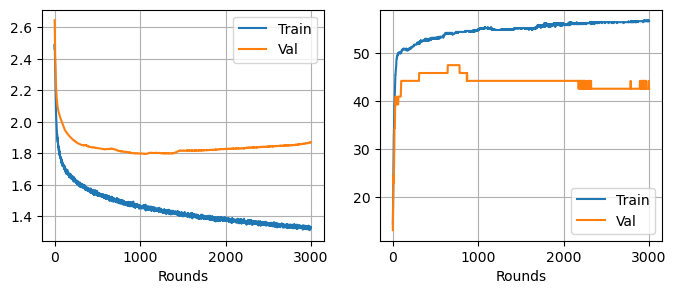

# ===== dropout: 0.25 ===== #
l2: 1e-06
[Epoch 0]  Train Loss: 2.4770678877830505  Train Acc: 7.52  Val Loss: 2.515995740890503  Train Acc: 14.75
[Epoch 500]  Train Loss: 1.5317426472902298  Train Acc: 54.88  Val Loss: 1.8369596004486084  Train Acc: 47.54
[Epoch 1000]  Train Loss: 1.4600731432437897  Train Acc: 55.08  Val Loss: 1.849031925201416  Train Acc: 49.18
[Epoch 1500]  Train Loss: 1.429908648133278  Train Acc: 55.08  Val Loss: 1.8863998651504517  Train Acc: 49.18
[Epoch 2000]  Train Loss: 1.4045015722513199  Train Acc: 55.69  Val Loss: 1.9055761098861694  Train Acc: 47.54
[Epoch 2500]  Train Loss: 1.367710918188095  Train Acc: 56.10  Val Loss: 1.9325283765792847  Train Acc: 47.54
[Epoch 2999]  Train Loss: 1.362913653254509  Train Acc: 56.10  Val Loss: 1.9447941780090332  Train Acc: 47.54


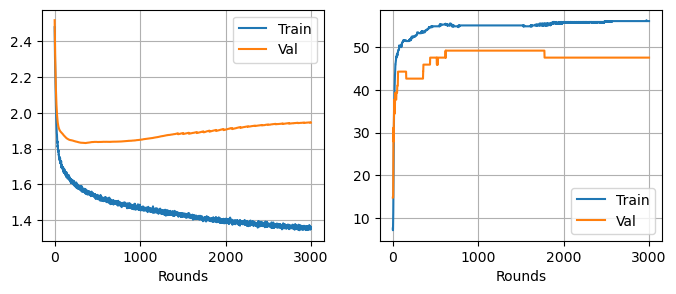

l2: 1e-05
[Epoch 0]  Train Loss: 2.4733829498291016  Train Acc: 7.52  Val Loss: 2.462676525115967  Train Acc: 9.84
[Epoch 500]  Train Loss: 1.5480055809020996  Train Acc: 54.47  Val Loss: 1.6724742650985718  Train Acc: 50.82
[Epoch 1000]  Train Loss: 1.4669304341077805  Train Acc: 54.47  Val Loss: 1.6408534049987793  Train Acc: 50.82
[Epoch 1500]  Train Loss: 1.4299335330724716  Train Acc: 55.08  Val Loss: 1.6358882188796997  Train Acc: 50.82
[Epoch 2000]  Train Loss: 1.4048620015382767  Train Acc: 55.49  Val Loss: 1.6412665843963623  Train Acc: 52.46
[Epoch 2500]  Train Loss: 1.376637041568756  Train Acc: 55.69  Val Loss: 1.6419328451156616  Train Acc: 52.46
[Epoch 2999]  Train Loss: 1.3689141273498535  Train Acc: 55.89  Val Loss: 1.6458483934402466  Train Acc: 52.46


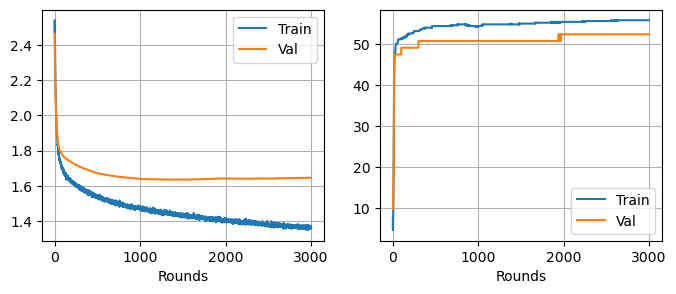

l2: 0.0001
[Epoch 0]  Train Loss: 2.4891747534275055  Train Acc: 9.15  Val Loss: 2.4089882373809814  Train Acc: 16.39
[Epoch 500]  Train Loss: 1.5126824527978897  Train Acc: 54.67  Val Loss: 1.8251769542694092  Train Acc: 45.90
[Epoch 1000]  Train Loss: 1.4502987563610077  Train Acc: 55.89  Val Loss: 1.8523225784301758  Train Acc: 47.54
[Epoch 1500]  Train Loss: 1.3908788710832596  Train Acc: 56.71  Val Loss: 1.871236801147461  Train Acc: 47.54
[Epoch 2000]  Train Loss: 1.3426511138677597  Train Acc: 56.50  Val Loss: 1.8813270330429077  Train Acc: 47.54
[Epoch 2500]  Train Loss: 1.3132833540439606  Train Acc: 56.91  Val Loss: 1.8949629068374634  Train Acc: 47.54
[Epoch 2999]  Train Loss: 1.2919007539749146  Train Acc: 57.32  Val Loss: 1.8991353511810303  Train Acc: 45.90


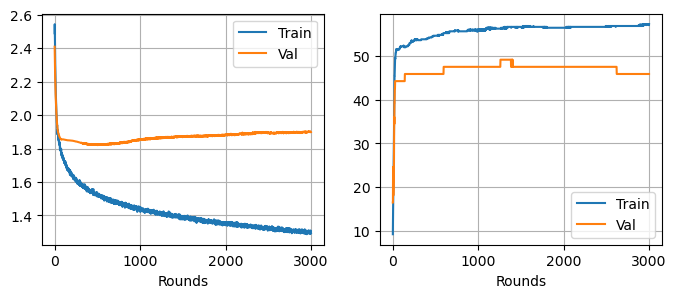

l2: 0.001
[Epoch 0]  Train Loss: 2.419182002544403  Train Acc: 5.49  Val Loss: 2.4714179039001465  Train Acc: 8.20
[Epoch 500]  Train Loss: 1.5475217401981354  Train Acc: 54.27  Val Loss: 1.8388490676879883  Train Acc: 49.18
[Epoch 1000]  Train Loss: 1.4724256992340088  Train Acc: 54.47  Val Loss: 1.8226131200790405  Train Acc: 49.18
[Epoch 1500]  Train Loss: 1.4460579752922058  Train Acc: 54.47  Val Loss: 1.8290776014328003  Train Acc: 49.18
[Epoch 2000]  Train Loss: 1.4178354740142822  Train Acc: 54.67  Val Loss: 1.8500275611877441  Train Acc: 49.18
[Epoch 2500]  Train Loss: 1.3993366211652756  Train Acc: 54.88  Val Loss: 1.8558911085128784  Train Acc: 50.82
[Epoch 2999]  Train Loss: 1.3844325989484787  Train Acc: 54.67  Val Loss: 1.855267882347107  Train Acc: 50.82


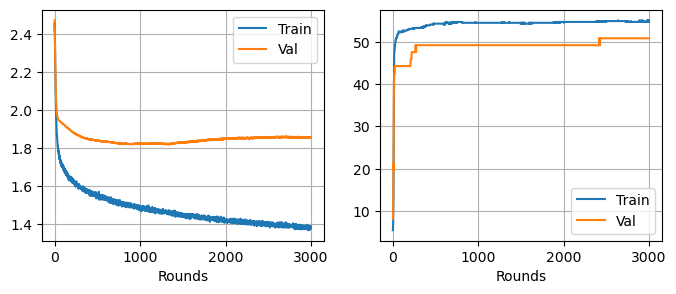

l2: 0.01
[Epoch 0]  Train Loss: 2.3996481597423553  Train Acc: 11.18  Val Loss: 2.4871909618377686  Train Acc: 8.20
[Epoch 500]  Train Loss: 1.5020258575677872  Train Acc: 54.47  Val Loss: 1.7119437456130981  Train Acc: 50.82
[Epoch 1000]  Train Loss: 1.4337635934352875  Train Acc: 55.69  Val Loss: 1.7868403196334839  Train Acc: 49.18
[Epoch 1500]  Train Loss: 1.3878781199455261  Train Acc: 56.10  Val Loss: 1.8167486190795898  Train Acc: 47.54
[Epoch 2000]  Train Loss: 1.353468805551529  Train Acc: 56.71  Val Loss: 1.825698733329773  Train Acc: 47.54
[Epoch 2500]  Train Loss: 1.3376514464616776  Train Acc: 57.11  Val Loss: 1.8678638935089111  Train Acc: 47.54
[Epoch 2999]  Train Loss: 1.3243633210659027  Train Acc: 57.32  Val Loss: 1.9073765277862549  Train Acc: 47.54


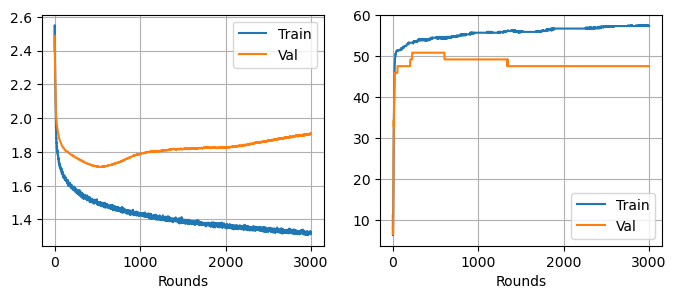

# ===== dropout: 0.3 ===== #
l2: 1e-06
[Epoch 0]  Train Loss: 2.425847202539444  Train Acc: 9.15  Val Loss: 2.3746635913848877  Train Acc: 21.31
[Epoch 500]  Train Loss: 1.524082601070404  Train Acc: 52.64  Val Loss: 1.75177800655365  Train Acc: 45.90
[Epoch 1000]  Train Loss: 1.464335948228836  Train Acc: 54.07  Val Loss: 1.6692591905593872  Train Acc: 49.18
[Epoch 1500]  Train Loss: 1.4103734642267227  Train Acc: 54.88  Val Loss: 1.6703590154647827  Train Acc: 50.82
[Epoch 2000]  Train Loss: 1.388418585062027  Train Acc: 55.28  Val Loss: 1.6768553256988525  Train Acc: 50.82
[Epoch 2500]  Train Loss: 1.3720628023147583  Train Acc: 55.89  Val Loss: 1.686779260635376  Train Acc: 50.82
[Epoch 2999]  Train Loss: 1.3443975150585175  Train Acc: 55.89  Val Loss: 1.701747179031372  Train Acc: 50.82


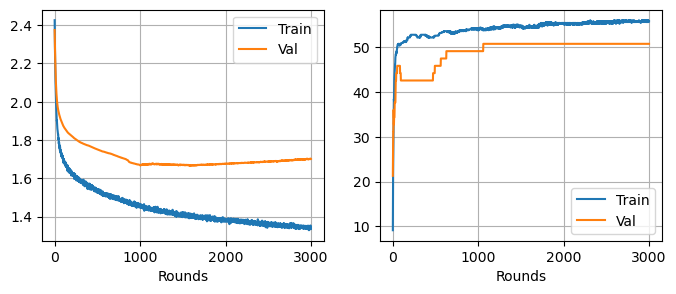

l2: 1e-05
[Epoch 0]  Train Loss: 2.524717152118683  Train Acc: 9.55  Val Loss: 3.0623984336853027  Train Acc: 14.75
[Epoch 500]  Train Loss: 1.5479132384061813  Train Acc: 54.07  Val Loss: 1.7523852586746216  Train Acc: 49.18
[Epoch 1000]  Train Loss: 1.4790313392877579  Train Acc: 55.28  Val Loss: 1.7960582971572876  Train Acc: 49.18
[Epoch 1500]  Train Loss: 1.4364188462495804  Train Acc: 55.08  Val Loss: 1.8288476467132568  Train Acc: 49.18
[Epoch 2000]  Train Loss: 1.3945731669664383  Train Acc: 56.10  Val Loss: 1.916421890258789  Train Acc: 49.18
[Epoch 2500]  Train Loss: 1.3455970585346222  Train Acc: 56.71  Val Loss: 2.00475811958313  Train Acc: 49.18
[Epoch 2999]  Train Loss: 1.3306975811719894  Train Acc: 57.32  Val Loss: 2.0589237213134766  Train Acc: 49.18


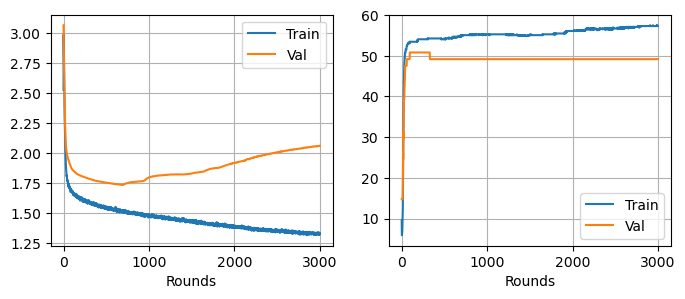

l2: 0.0001
[Epoch 0]  Train Loss: 2.5002581775188446  Train Acc: 6.91  Val Loss: 2.4935302734375  Train Acc: 18.03
[Epoch 500]  Train Loss: 1.544518455862999  Train Acc: 53.66  Val Loss: 1.667075514793396  Train Acc: 49.18
[Epoch 1000]  Train Loss: 1.4693830758333206  Train Acc: 55.08  Val Loss: 1.6176886558532715  Train Acc: 49.18
[Epoch 1500]  Train Loss: 1.421273872256279  Train Acc: 55.49  Val Loss: 1.5880628824234009  Train Acc: 49.18
[Epoch 2000]  Train Loss: 1.3853260576725006  Train Acc: 56.50  Val Loss: 1.5828253030776978  Train Acc: 49.18
[Epoch 2500]  Train Loss: 1.3679142594337463  Train Acc: 56.50  Val Loss: 1.5727485418319702  Train Acc: 50.82
[Epoch 2999]  Train Loss: 1.3393529504537582  Train Acc: 56.91  Val Loss: 1.5747052431106567  Train Acc: 50.82


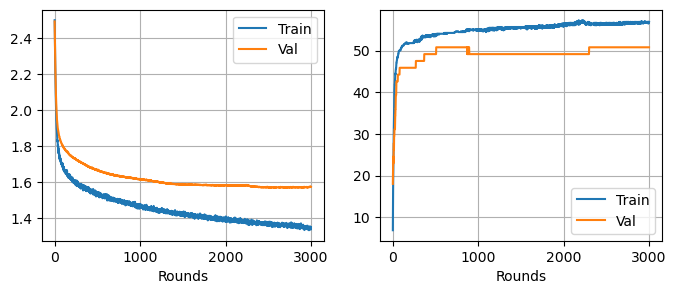

l2: 0.001
[Epoch 0]  Train Loss: 2.4003876745700836  Train Acc: 7.72  Val Loss: 2.5221688747406006  Train Acc: 3.28
[Epoch 500]  Train Loss: 1.4597669690847397  Train Acc: 55.49  Val Loss: 1.8547132015228271  Train Acc: 44.26
[Epoch 1000]  Train Loss: 1.389115035533905  Train Acc: 56.50  Val Loss: 1.8384109735488892  Train Acc: 45.90
[Epoch 1500]  Train Loss: 1.3373324275016785  Train Acc: 56.50  Val Loss: 1.8450665473937988  Train Acc: 45.90
[Epoch 2000]  Train Loss: 1.3154934719204903  Train Acc: 57.52  Val Loss: 1.8767755031585693  Train Acc: 47.54
[Epoch 2500]  Train Loss: 1.2767378240823746  Train Acc: 58.74  Val Loss: 1.900214433670044  Train Acc: 47.54
[Epoch 2999]  Train Loss: 1.2461334764957428  Train Acc: 58.94  Val Loss: 1.9152624607086182  Train Acc: 47.54


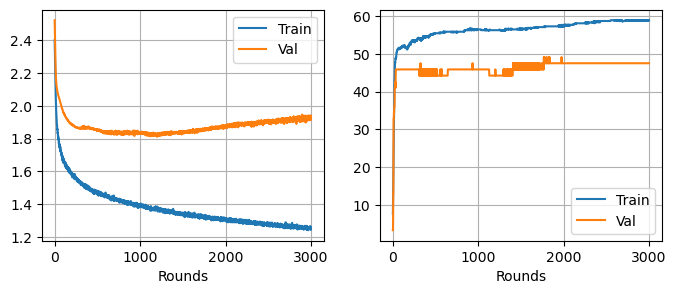

l2: 0.01
[Epoch 0]  Train Loss: 2.445866823196411  Train Acc: 9.15  Val Loss: 2.6231603622436523  Train Acc: 3.28
[Epoch 500]  Train Loss: 1.5040297508239746  Train Acc: 54.67  Val Loss: 1.7553510665893555  Train Acc: 49.18
[Epoch 1000]  Train Loss: 1.4219267517328262  Train Acc: 55.69  Val Loss: 1.8062020540237427  Train Acc: 50.82
[Epoch 1500]  Train Loss: 1.3765799850225449  Train Acc: 55.89  Val Loss: 1.8431379795074463  Train Acc: 50.82
[Epoch 2000]  Train Loss: 1.3534657806158066  Train Acc: 56.10  Val Loss: 1.8752105236053467  Train Acc: 50.82
[Epoch 2500]  Train Loss: 1.3183628618717194  Train Acc: 56.30  Val Loss: 1.8889602422714233  Train Acc: 50.82
[Epoch 2999]  Train Loss: 1.2917678356170654  Train Acc: 56.91  Val Loss: 1.8953454494476318  Train Acc: 52.46


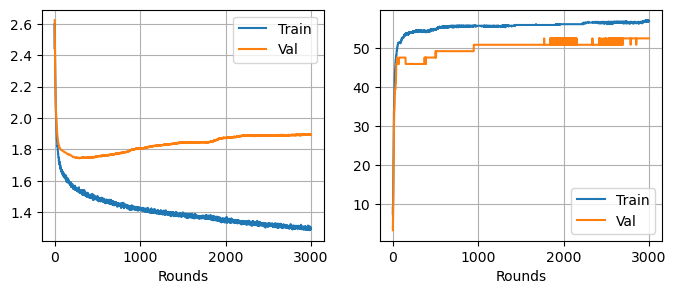

best set of exp3:  [50.819672131147534, 1.6155105452537537, 0.1, 0.01]


In [ ]:
seed = 1228
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = 'exp2'

# ====== Model Capacity ====== #
args.in_dim = exp0_best_set[2]
args.out_dim = out_dim
args.hid_dim = exp2_best_set[2]
args.act = 'relu'
args.n_layer = exp2_best_set[3]

# ====== Regularization ======= #
args.dropout = 0      #########################
args.use_bn = True
args.l2 = 0       #########################
args.use_xavier = True

# ====== Optimizer & Training ====== #
args.optim = exp1_best_set[2]
args.lr = exp1_best_set[3]

# ====== Federated Learning Parameters ====== #
args.epochs = 3000
args.train_batch_size = 64
args.test_batch_size = 64

args.feat = exp0_best_set[2]


#================================================================================#
name_var1 = 'dropout'
name_var2 = 'l2'
list_var1 = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
list_var2 = np.logspace(-6, -2, 5)

exp3_best_set = [0, 100000, 0, 0]

for var1 in list_var1:
    print(f'# ===== {name_var1}: {var1} ===== #')
    setattr(args, name_var1, var1)
    
    for var2 in list_var2:
        setattr(args, name_var2, var2)
        print(f'{name_var2}: {var2}')

        partition = make_dataset(feature_idx, sleep_data, survey_data, args)

        train_losses, val_losses, train_acces, val_acces = experiment(partition, args)
        plot_loss(train_losses, val_losses, train_acces, val_acces)

        mean_loss, mean_acc = np.mean(val_losses[-500:]), np.mean(val_acces[-500:])

        if mean_acc > exp3_best_set[0] and (mean_loss < exp3_best_set[1]):
            exp3_best_set[0], exp3_best_set[1], exp3_best_set[2], exp3_best_set[3] = mean_acc, mean_loss, var1, var2

print('best set of exp3: ', exp3_best_set)